# **Bibliotecas e Funções**

In [3]:
%%capture

!pip install shap
!pip install optuna
!pip install cmaes

In [4]:
seed = 7
import pandas as pd
import numpy as np

# Graphs
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix

# Models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Optuna
import optuna
from optuna.samplers import RandomSampler, TPESampler, CmaEsSampler
from optuna.visualization import plot_optimization_history

O arquivo 'functions_pred_cruzada' contém as funções que serão utilizadas para selecionar, pré-processar e treinar e validar os modelos de machine learning

In [5]:
!gdown 1uVoArwRTJmvbyFLyFniwFvWGHMfiNIWO --quiet

from functions_pred_cruzada import *

# **Dados**

In [6]:
!gdown 19BTOHjgR9mTjI8Sa8pl7M1dPJy5UmwDo --quiet # Mais incidentes treino
!gdown 194o9VVsCwcnt3Cp1oBbJdd0Sb_N2LOIF --quiet # Mais incidentes teste

In [7]:
df_incid_treino = pd.read_csv('incid_treino.csv')
print(df_incid_treino.shape)
df_incid_treino.head(3)

(302582, 25)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,EC,CIRURGIA,RADIO,QUIMIO,HORMONIO,...,ANODIAG,DRS,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,TOPOGRUP,sobrevida_3anos
0,0.900006,1.028664,-1.095067,-0.714301,0.958036,1.605010,-1.664088,-0.567847,0.737288,-0.078540,...,0.933829,0.327366,0.896330,-1.117133,0.396181,0.154944,0.964441,-0.475073,Colorretal,0
1,2.017011,0.078323,0.709472,1.270371,-0.915765,-1.584428,0.545300,1.015205,-1.536653,0.848079,...,-1.183185,-0.851058,-1.799187,0.743452,0.599581,-0.940442,-1.048322,-0.514970,Mama,1
2,0.474908,1.091681,-0.572151,1.167751,-0.344597,1.142798,0.315561,-0.242155,-0.156064,-0.038330,...,-1.672914,-0.765173,0.926783,-0.202185,0.393904,-0.406625,-0.776427,-0.218179,Pele,1


In [8]:
df_incid_teste = pd.read_csv('incid_teste.csv')
print(df_incid_teste.shape)
df_incid_teste.head(3)

(100864, 25)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,EC,CIRURGIA,RADIO,QUIMIO,HORMONIO,...,ANODIAG,DRS,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,TOPOGRUP,sobrevida_3anos
0,0.366829,-0.972134,1.141405,1.343451,0.958036,-0.047542,0.60093,-0.567847,0.737288,-0.078540,...,-1.734289,1.587885,0.660606,-1.716753,0.396181,1.180668,-1.036870,-0.475073,Colorretal,1
1,-0.166349,-0.972134,-0.649610,1.343451,0.958036,-0.873817,0.60093,1.761039,0.737288,-0.078540,...,-0.209650,1.767959,-0.282288,0.900562,-0.968850,0.154944,-1.036870,-0.475073,Colorretal,1
2,-0.623264,0.078323,-0.758504,1.270371,-0.915765,-1.584428,0.54530,1.015205,-1.536653,0.848079,...,-0.446767,-0.851058,-0.888302,0.743452,-0.803767,0.967430,-1.048322,-0.514970,Mama,1


In [9]:
df_incid_treino.TOPOGRUP.value_counts()

Mama             78399
Pele             75662
Próstata         62583
Colorretal       42083
Pulmão           27753
Colo de Útero    16102
Name: TOPOGRUP, dtype: int64

In [10]:
um = ['Pulmão', 'Colo de Útero']
dois = ['Colo de Útero', 'Mama', 'Pulmão']

df1_treino = df_incid_treino[df_incid_treino.TOPOGRUP.isin(um)]
df1_teste = df_incid_teste[df_incid_teste.TOPOGRUP.isin(um)]

df2_treino = df_incid_treino[df_incid_treino.TOPOGRUP.isin(dois)]
df2_teste = df_incid_teste[df_incid_teste.TOPOGRUP.isin(dois)]

df1_treino.shape, df1_teste.shape, df2_treino.shape, df2_teste.shape

((43855, 25), (14620, 25), (122254, 25), (40753, 25))

In [11]:
# DFs de teste para cada tipo
mama_teste = df_incid_teste[df_incid_teste.TOPOGRUP == 'Mama']
# colo_teste = df_incid_teste[df_incid_teste.TOPOGRUP == 'Colorretal']
pulm_teste = df_incid_teste[df_incid_teste.TOPOGRUP == 'Pulmão']
colo_utero_teste = df_incid_teste[df_incid_teste.TOPOGRUP == 'Colo de Útero']

mama_teste.shape, pulm_teste.shape, colo_utero_teste.shape

((26133, 25), (9252, 25), (5368, 25))

In [12]:
from sklearn.utils import shuffle

df1_treino = shuffle(df1_treino, random_state=seed)
df1_teste = shuffle(df1_teste, random_state=seed)

df2_treino = shuffle(df2_treino, random_state=seed)
df2_teste = shuffle(df2_teste, random_state=seed)

# **Pulmão com Colo de Útero**

In [13]:
df1_treino.TOPOGRUP.value_counts()

Pulmão           27753
Colo de Útero    16102
Name: TOPOGRUP, dtype: int64

In [14]:
# Valores faltantes
df1_treino.isna().sum().sort_values(ascending=False)

IDADE                 0
CONSDIAG              0
TOPOGRUP              0
presenca_rec          0
IBGE_idem_IBGEATEN    0
ESCOLARI_preench      0
HABILIT2              0
IBGEATEN              0
RRAS                  0
DRS                   0
ANODIAG               0
DIAGTRAT              0
OUTROS                0
SEXO                  0
IMUNO                 0
TMO                   0
HORMONIO              0
QUIMIO                0
RADIO                 0
CIRURGIA              0
EC                    0
DIAGPREV              0
CATEATEND             0
IBGE                  0
sobrevida_3anos       0
dtype: int64

In [15]:
# Quantidade de pacientes em cada classe da saída
df1_treino.sobrevida_3anos.value_counts()

0    30947
1    12908
Name: sobrevida_3anos, dtype: int64

## **Pré-processamento**

In [16]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df1_treino['TOPOGRUP'] = oe.fit_transform(df1_treino[['TOPOGRUP']])
df1_teste['TOPOGRUP'] = oe.transform(df1_teste[['TOPOGRUP']])

ss = StandardScaler()
df1_treino['TOPOGRUP'] = ss.fit_transform(df1_treino[['TOPOGRUP']])
df1_teste['TOPOGRUP'] = ss.transform(df1_teste[['TOPOGRUP']])

In [17]:
# Dados pré-processados
list_drop = ['sobrevida_3anos']

# Treino
X_train = df1_treino.drop(columns=list_drop).copy()
y_train = df1_treino.sobrevida_3anos.copy()

# Teste
X_test = df1_teste.drop(columns=list_drop).copy()
y_test = df1_teste.sobrevida_3anos.copy()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((43855, 24), (43855,), (14620, 24), (14620,))

In [18]:
feat_cols = X_train.columns
feat_cols

Index(['IDADE', 'SEXO', 'IBGE', 'CATEATEND', 'DIAGPREV', 'EC', 'CIRURGIA',
       'RADIO', 'QUIMIO', 'HORMONIO', 'TMO', 'IMUNO', 'OUTROS', 'CONSDIAG',
       'DIAGTRAT', 'ANODIAG', 'DRS', 'RRAS', 'IBGEATEN', 'HABILIT2',
       'ESCOLARI_preench', 'IBGE_idem_IBGEATEN', 'presenca_rec', 'TOPOGRUP'],
      dtype='object')

## **Treinamento e validação dos modelos de machine learning**

### **XGBoost**


#### **Modelo base**

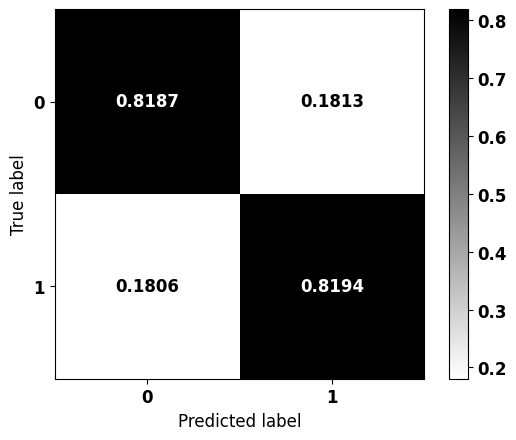


              precision    recall  f1-score   support

           0     0.9158    0.8187    0.8645     10317
           1     0.6534    0.8194    0.7271      4303

    accuracy                         0.8189     14620
   macro avg     0.7846    0.8191    0.7958     14620
weighted avg     0.8386    0.8189    0.8241     14620



In [19]:
# Criação e treinamento do modelo XGBoost
xgb = XGBClassifier(max_depth=5,
                    scale_pos_weight=2.415,
                    random_state=seed)

xgb.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(xgb, X_test, y_test)

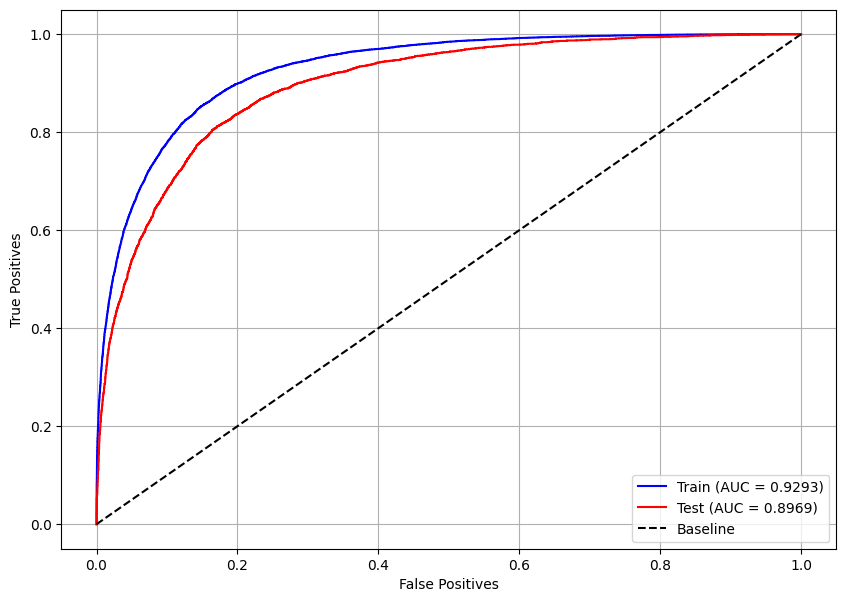

In [25]:
# Curva ROC
plot_roc_curve(xgb, X_train, X_test, y_train, y_test)

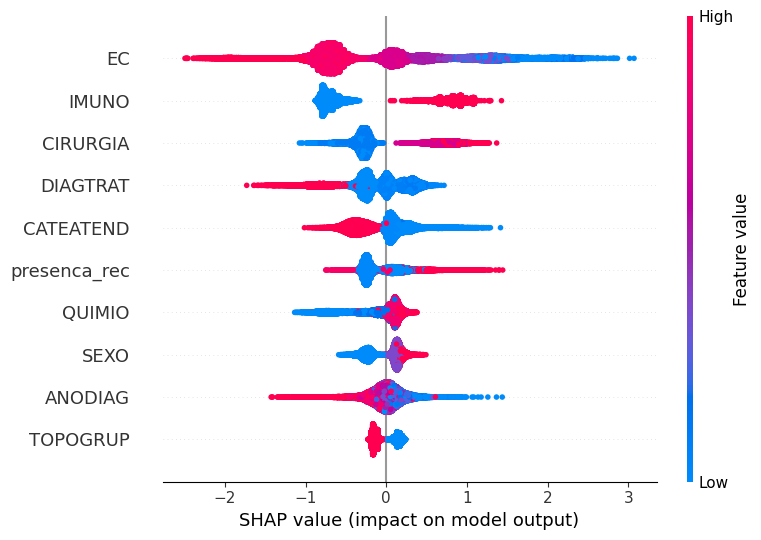

In [26]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb, X_train, feat_cols)

#### **Optuna**

In [20]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 5)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05)
    gamma = trial.suggest_float('gamma', 0.0, 0.3, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = XGBClassifier(n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        gamma=gamma,
                        min_child_weight=min_child_weight,
                        colsample_bytree=colsample_bytree,
                        random_state=seed,
                        n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [29]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 105,
 'max_depth': 5,
 'learning_rate': 0.2,
 'gamma': 0.0,
 'min_child_weight': 5,
 'colsample_bytree': 0.4}

In [ ]:
pesos = np.round(np.arange(2.25, 2.29, 0.001), 3)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

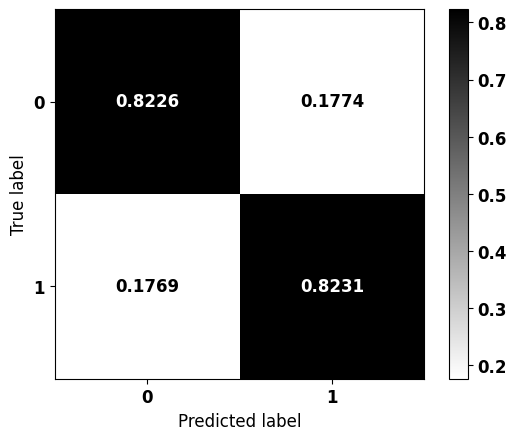


              precision    recall  f1-score   support

           0     0.9177    0.8226    0.8676     10317
           1     0.6593    0.8231    0.7322      4303

    accuracy                         0.8228     14620
   macro avg     0.7885    0.8229    0.7999     14620
weighted avg     0.8417    0.8228    0.8277     14620



In [22]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 2.259

xgb_rand = XGBClassifier()
xgb_rand.set_params(**params)

xgb_rand.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_rand, X_test, y_test)

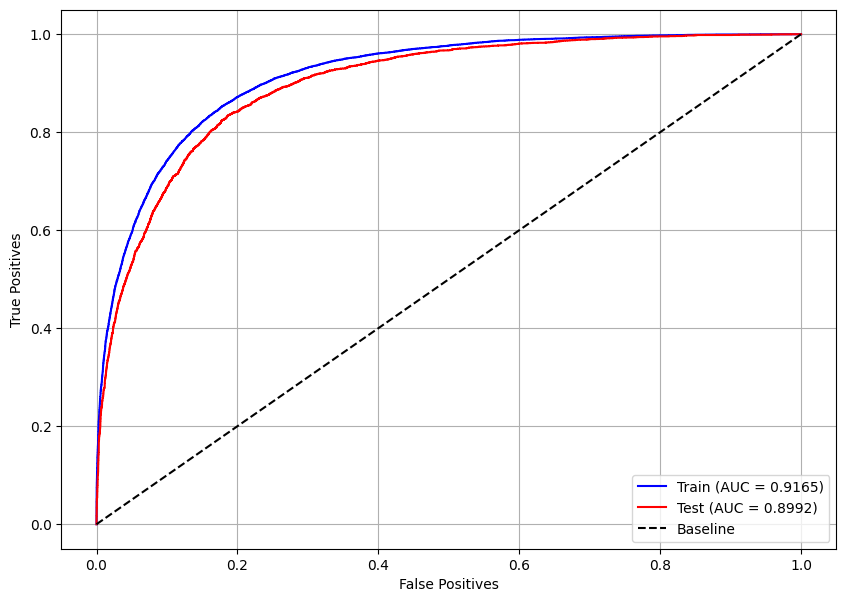

In [23]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_rand, X_train, X_test, y_train, y_test)

TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [25]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 111,
 'max_depth': 5,
 'learning_rate': 0.2,
 'gamma': 0.1,
 'min_child_weight': 6,
 'colsample_bytree': 0.4}

In [ ]:
pesos = np.round(np.arange(2.25, 2.29, 0.001), 3)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

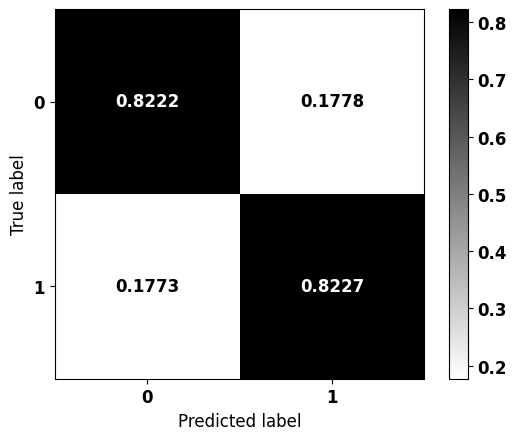


              precision    recall  f1-score   support

           0     0.9175    0.8222    0.8672     10317
           1     0.6587    0.8227    0.7316      4303

    accuracy                         0.8224     14620
   macro avg     0.7881    0.8225    0.7994     14620
weighted avg     0.8413    0.8224    0.8273     14620



In [29]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 2.288

xgb_tpe = XGBClassifier()
xgb_tpe.set_params(**params)

xgb_tpe.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_tpe, X_test, y_test)

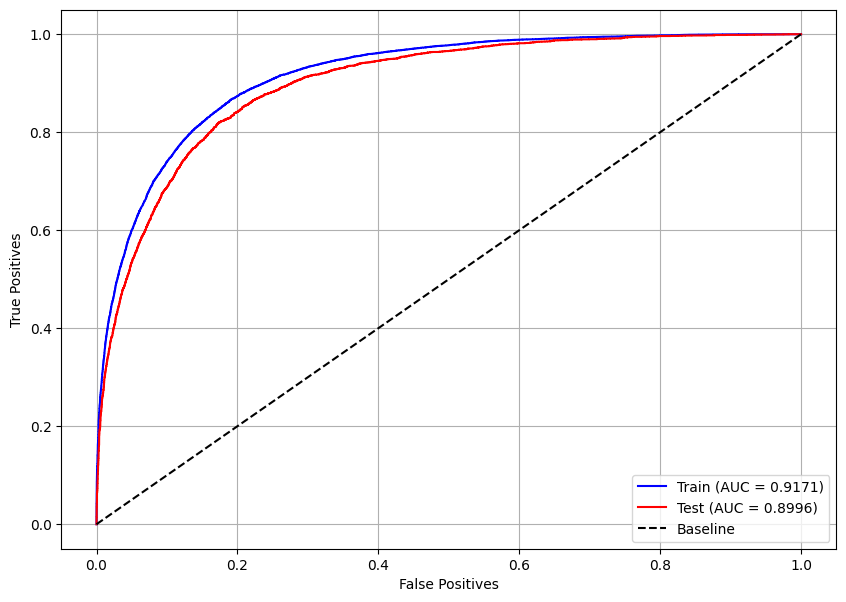

In [30]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_tpe, X_train, X_test, y_train, y_test)

CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [32]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 143,
 'max_depth': 5,
 'learning_rate': 0.15000000000000002,
 'gamma': 0.2,
 'min_child_weight': 5,
 'colsample_bytree': 0.5}

In [ ]:
pesos = np.round(np.arange(2.25, 2.3, 0.001), 3)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

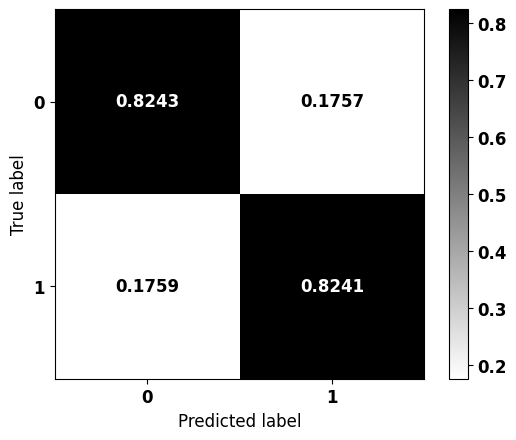


              precision    recall  f1-score   support

           0     0.9183    0.8243    0.8687     10317
           1     0.6617    0.8241    0.7340      4303

    accuracy                         0.8242     14620
   macro avg     0.7900    0.8242    0.8014     14620
weighted avg     0.8427    0.8242    0.8291     14620



In [36]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 2.277

xgb_cma = XGBClassifier()
xgb_cma.set_params(**params)

xgb_cma.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_cma, X_test, y_test)

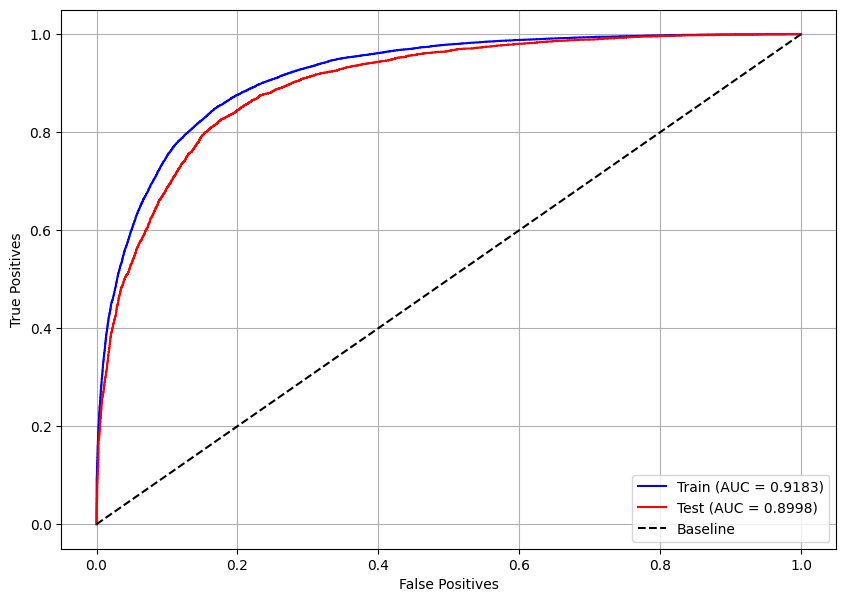

In [37]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_cma, X_train, X_test, y_train, y_test)

**Modelo Otimizado**

In [38]:
# Melhor modelo
models = [xgb_rand, xgb_tpe, xgb_cma]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15000000000000002,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=143, n_jobs=None,
              num_parallel_tree=None, random_state=7, ...)


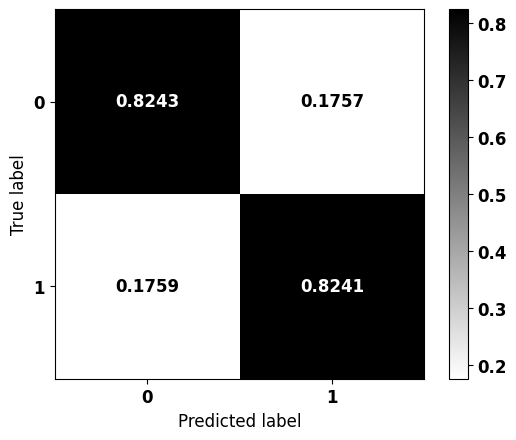


              precision    recall  f1-score   support

           0     0.9183    0.8243    0.8687     10317
           1     0.6617    0.8241    0.7340      4303

    accuracy                         0.8242     14620
   macro avg     0.7900    0.8242    0.8014     14620
weighted avg     0.8427    0.8242    0.8291     14620



In [39]:
# Modelo com os melhores parâmetros
params = best.get_params()

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

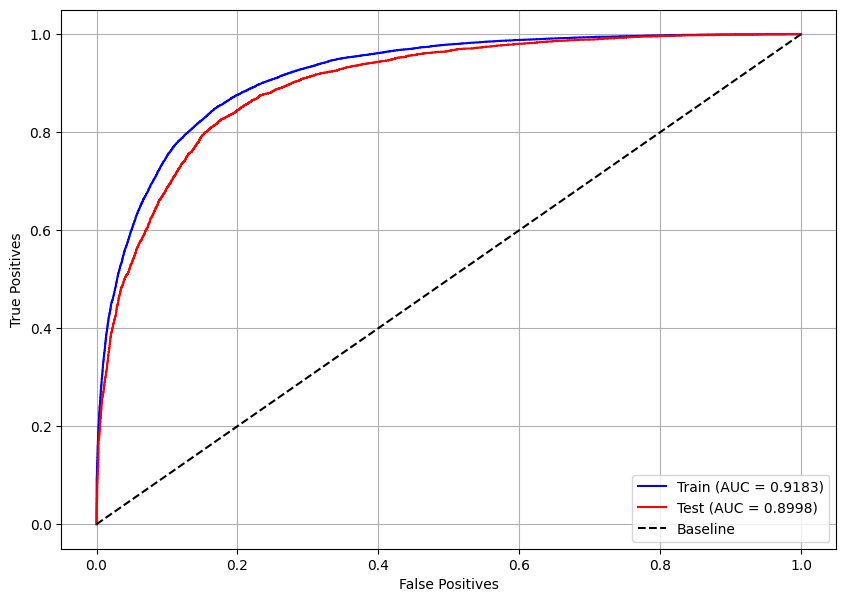

In [40]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

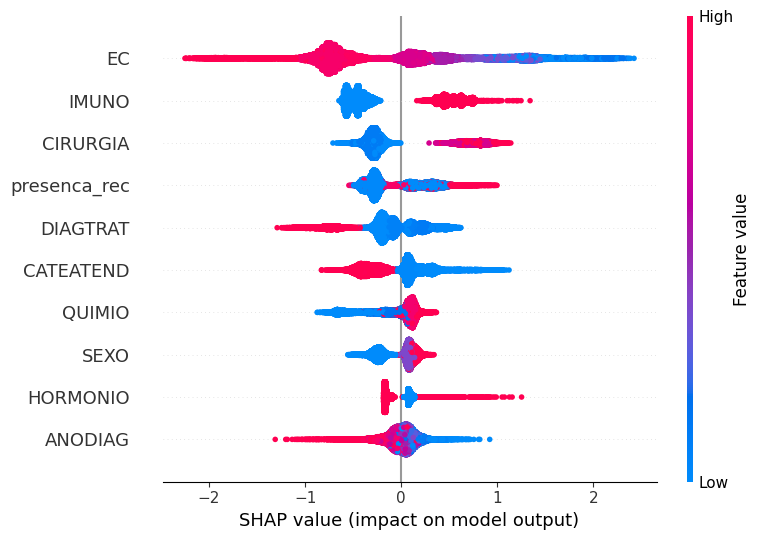

In [41]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb_optuna, X_train, feat_cols)

### **LightGBM**


#### **Modelo base**

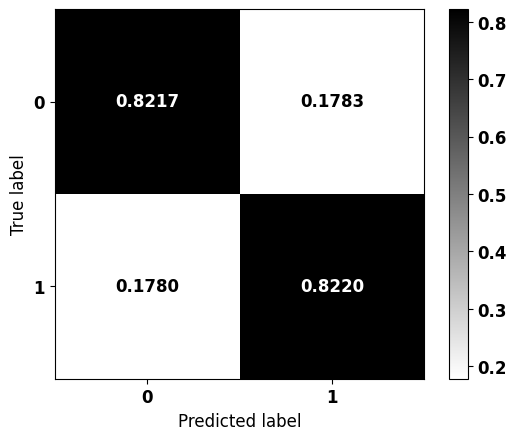


              precision    recall  f1-score   support

           0     0.9171    0.8217    0.8668     10317
           1     0.6578    0.8220    0.7308      4303

    accuracy                         0.8218     14620
   macro avg     0.7875    0.8218    0.7988     14620
weighted avg     0.8408    0.8218    0.8267     14620



In [51]:
# Criação e treinamento do modelo LightGBM
lgbm = LGBMClassifier(max_depth=10,
                      class_weight={0:1, 1:2.267},
                      random_state=seed,
                      verbose=-1)

lgbm.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(lgbm, X_test, y_test)

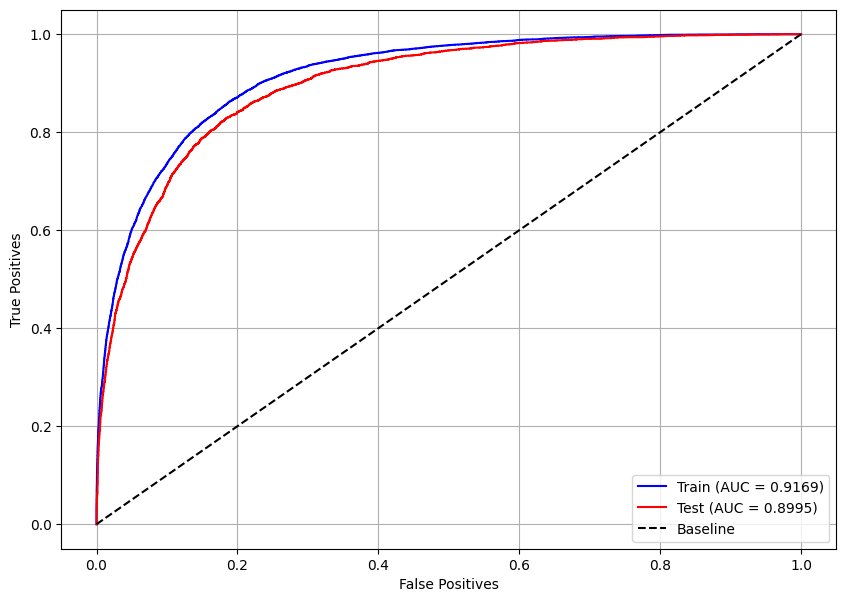

In [52]:
# Curva ROC
plot_roc_curve(lgbm, X_train, X_test, y_train, y_test)

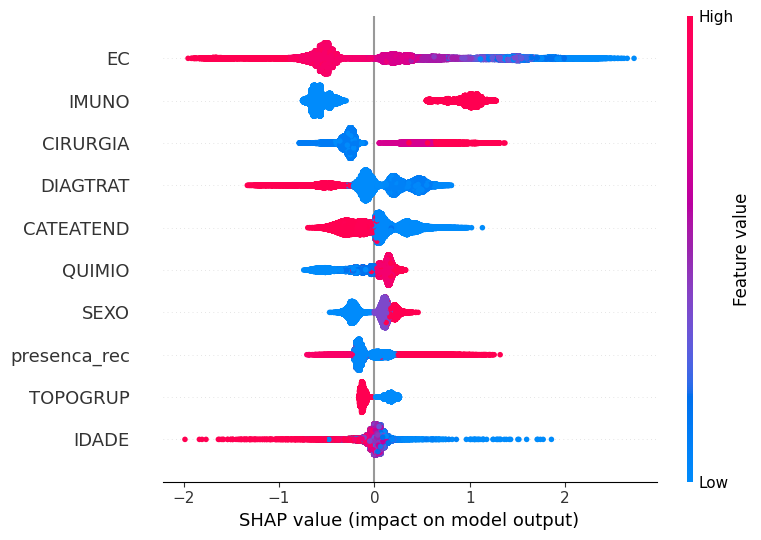

In [53]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm, X_train, feat_cols)

#### **Optuna**

In [54]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.01)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = LGBMClassifier(n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         colsample_bytree=colsample_bytree,
                         random_state=seed,
                         verbose=-1,
                         n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [56]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 102,
 'max_depth': 6,
 'learning_rate': 0.2,
 'min_child_weight': 1,
 'colsample_bytree': 0.3}

In [ ]:
pesos = np.round(np.arange(2.25, 2.3, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:1, 1:i}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

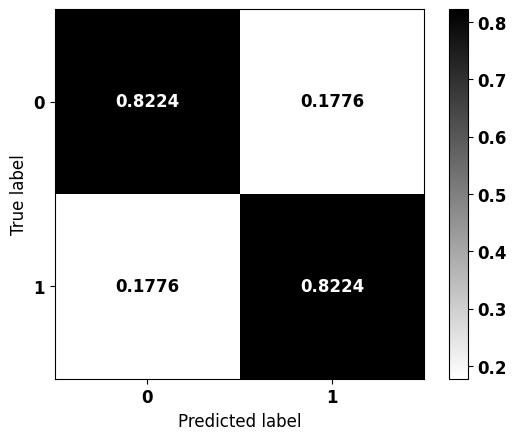


              precision    recall  f1-score   support

           0     0.9174    0.8224    0.8673     10317
           1     0.6589    0.8224    0.7317      4303

    accuracy                         0.8224     14620
   macro avg     0.7882    0.8224    0.7995     14620
weighted avg     0.8413    0.8224    0.8274     14620



In [62]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:1, 1:2.257}

lgbm_rand = LGBMClassifier(verbose=-1)
lgbm_rand.set_params(**params)

lgbm_rand.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_rand, X_test, y_test)

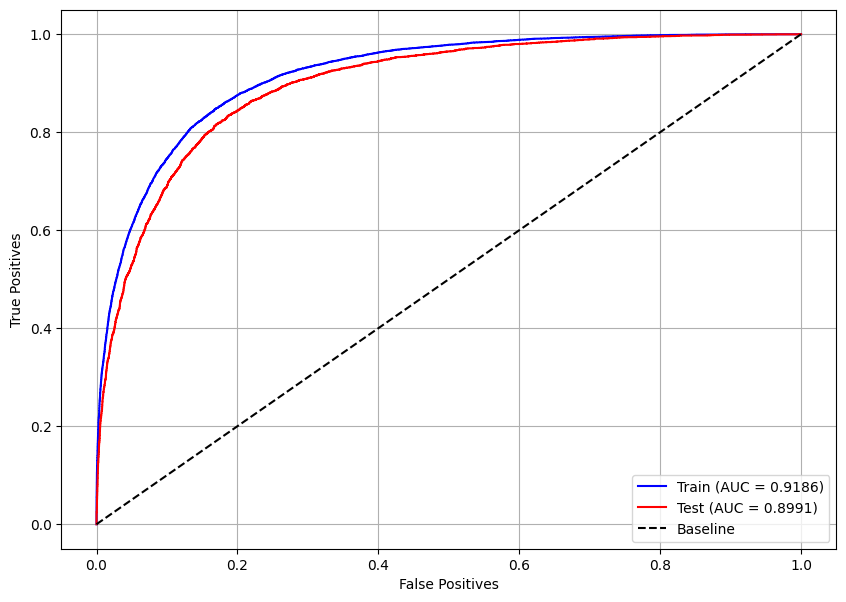

In [63]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_rand, X_train, X_test, y_train, y_test)

TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [65]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 139,
 'max_depth': 10,
 'learning_rate': 0.1,
 'min_child_weight': 1,
 'colsample_bytree': 0.6000000000000001}

In [ ]:
pesos = np.round(np.arange(2.3, 2.34, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:1, 1:i}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

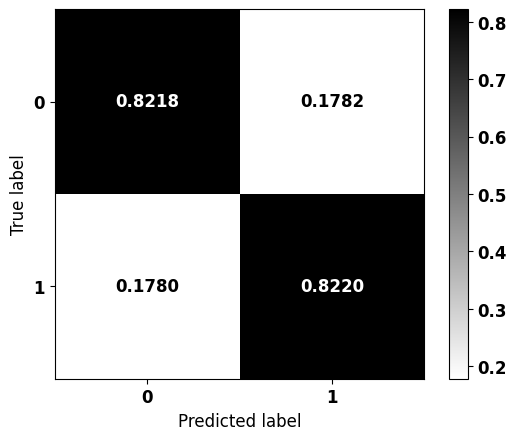


              precision    recall  f1-score   support

           0     0.9171    0.8218    0.8668     10317
           1     0.6579    0.8220    0.7309      4303

    accuracy                         0.8218     14620
   macro avg     0.7875    0.8219    0.7988     14620
weighted avg     0.8408    0.8218    0.8268     14620



In [70]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:1, 1:2.303}

lgbm_tpe = LGBMClassifier(verbose=-1)
lgbm_tpe.set_params(**params)

lgbm_tpe.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_tpe, X_test, y_test)

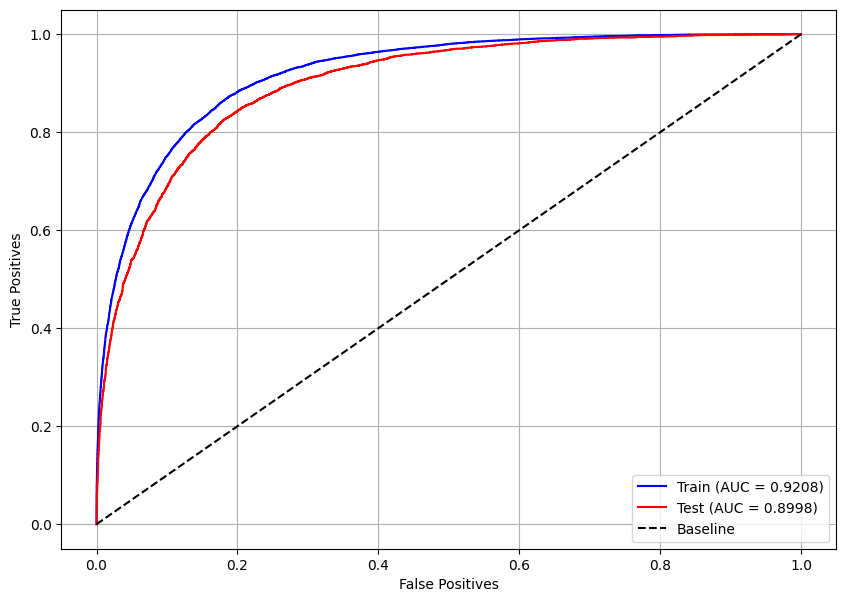

In [71]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_tpe, X_train, X_test, y_train, y_test)

CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [73]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 104,
 'max_depth': 9,
 'learning_rate': 0.12000000000000001,
 'min_child_weight': 4,
 'colsample_bytree': 0.6000000000000001}

In [ ]:
pesos = np.round(np.arange(2.24, 2.3, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:1, 1:i}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

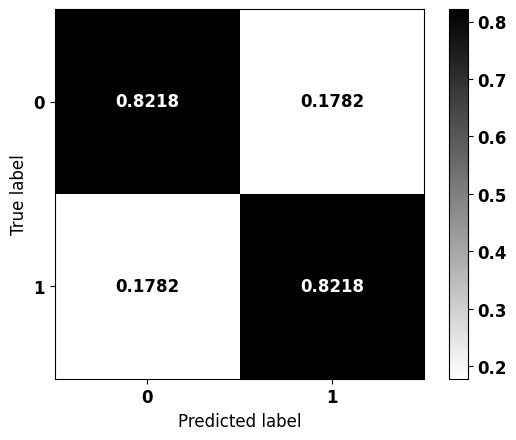


              precision    recall  f1-score   support

           0     0.9170    0.8218    0.8668     10317
           1     0.6579    0.8218    0.7307      4303

    accuracy                         0.8218     14620
   macro avg     0.7874    0.8218    0.7988     14620
weighted avg     0.8408    0.8218    0.8267     14620



In [81]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:1, 1:2.265}

lgbm_cma = LGBMClassifier(verbose=-1)
lgbm_cma.set_params(**params)

lgbm_cma.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_cma, X_test, y_test)

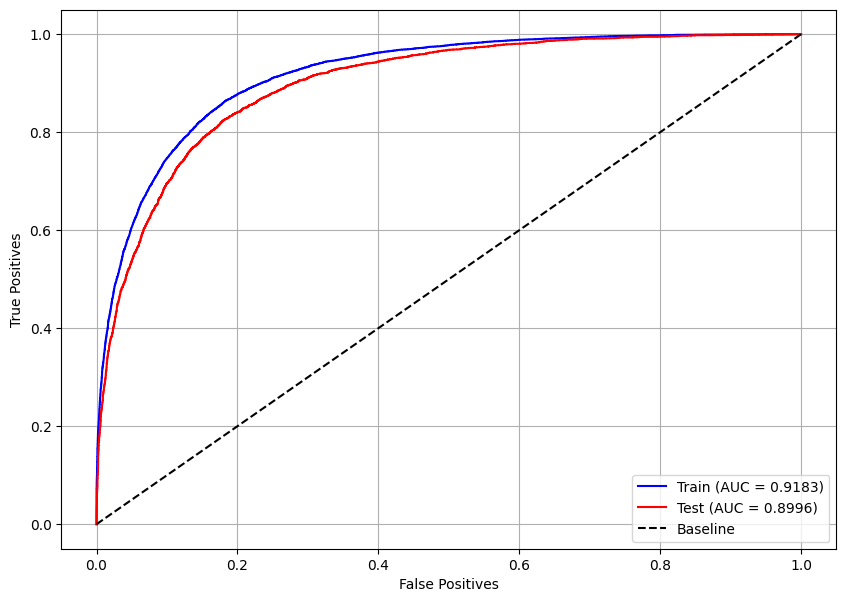

In [82]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_cma, X_train, X_test, y_train, y_test)

**Modelo Otimizado**

In [83]:
# Melhor modelo
models = [lgbm_rand, lgbm_tpe, lgbm_cma]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

LGBMClassifier(class_weight={0: 1, 1: 2.257}, colsample_bytree=0.3,
               learning_rate=0.2, max_depth=6, min_child_weight=1,
               n_estimators=102, random_state=7, verbose=-1)


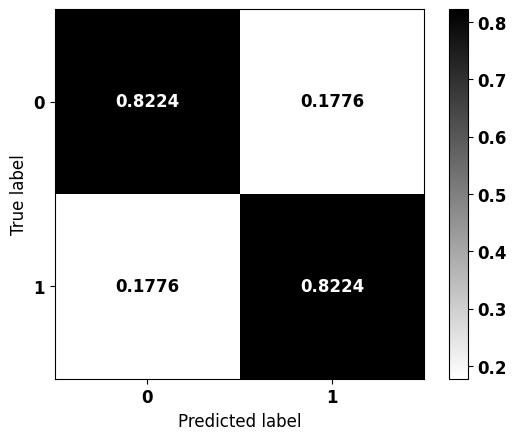


              precision    recall  f1-score   support

           0     0.9174    0.8224    0.8673     10317
           1     0.6589    0.8224    0.7317      4303

    accuracy                         0.8224     14620
   macro avg     0.7882    0.8224    0.7995     14620
weighted avg     0.8413    0.8224    0.8274     14620



In [84]:
# Modelo com os melhores parâmetros
params = best.get_params()

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

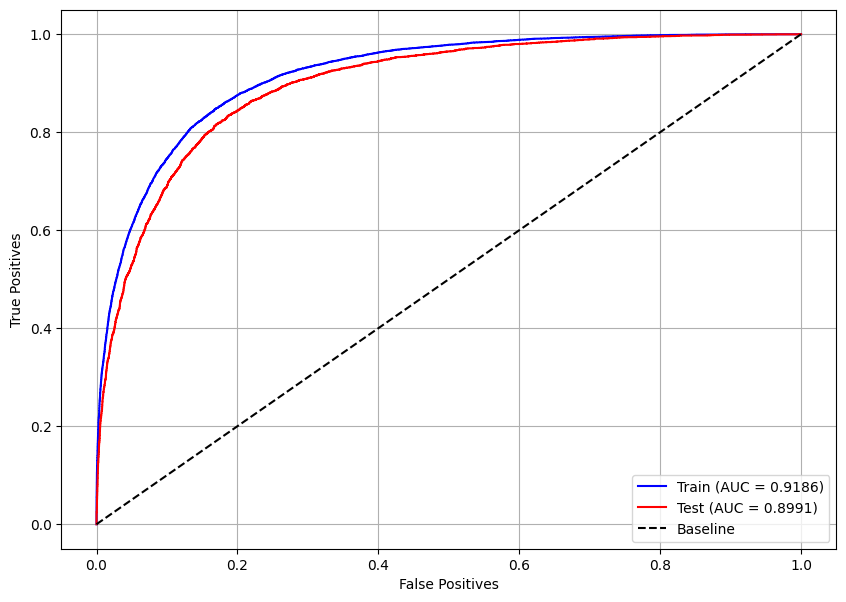

In [85]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

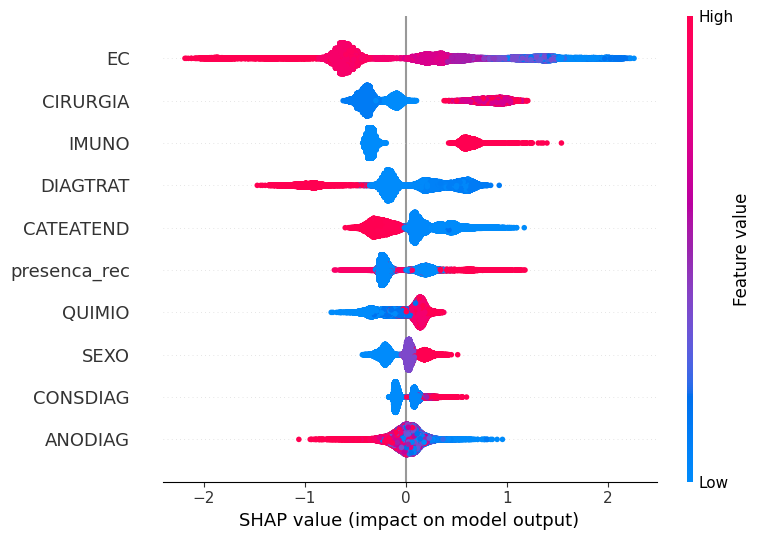

In [86]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm_optuna, X_train, feat_cols)

## **Testes cruzados**

In [87]:
# Melhor modelo
models = [xgb, xgb_optuna, lgbm, lgbm_optuna]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15000000000000002,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=143, n_jobs=None,
              num_parallel_tree=None, random_state=7, ...)


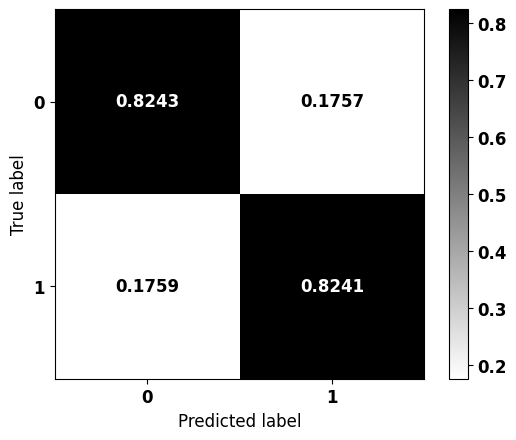


              precision    recall  f1-score   support

           0     0.9183    0.8243    0.8687     10317
           1     0.6617    0.8241    0.7340      4303

    accuracy                         0.8242     14620
   macro avg     0.7900    0.8242    0.8014     14620
weighted avg     0.8427    0.8242    0.8291     14620



In [88]:
plot_confusion_matrix(best, X_test, y_test)

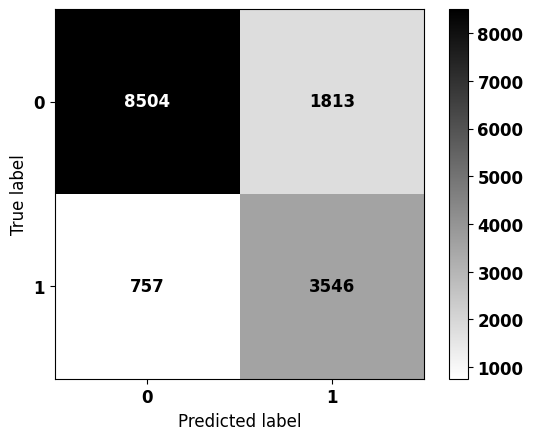


              precision    recall  f1-score   support

           0     0.9183    0.8243    0.8687     10317
           1     0.6617    0.8241    0.7340      4303

    accuracy                         0.8242     14620
   macro avg     0.7900    0.8242    0.8014     14620
weighted avg     0.8427    0.8242    0.8291     14620



In [89]:
plot_confusion_matrix(best, X_test, y_test, norm=False)

In [90]:
# Pulmão
X_test_pulm = pulm_teste.drop(columns=list_drop).copy()
y_test_pulm = pulm_teste.sobrevida_3anos.copy()

X_test_pulm['TOPOGRUP'] = oe.transform(X_test_pulm[['TOPOGRUP']])
X_test_pulm['TOPOGRUP'] = ss.transform(X_test_pulm[['TOPOGRUP']])

# Colo de Útero
X_test_colo_utero = colo_utero_teste.drop(columns=list_drop).copy()
y_test_colo_utero = colo_utero_teste.sobrevida_3anos.copy()

X_test_colo_utero['TOPOGRUP'] = oe.transform(X_test_colo_utero[['TOPOGRUP']])
X_test_colo_utero['TOPOGRUP'] = ss.transform(X_test_colo_utero[['TOPOGRUP']])

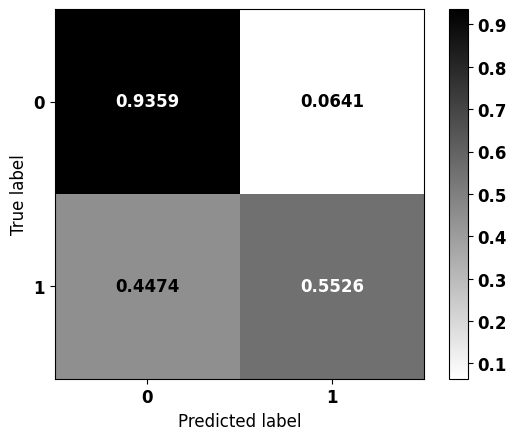


              precision    recall  f1-score   support

           0     0.9308    0.9359    0.9334      8007
           1     0.5729    0.5526    0.5626      1245

    accuracy                         0.8843      9252
   macro avg     0.7518    0.7443    0.7480      9252
weighted avg     0.8826    0.8843    0.8835      9252



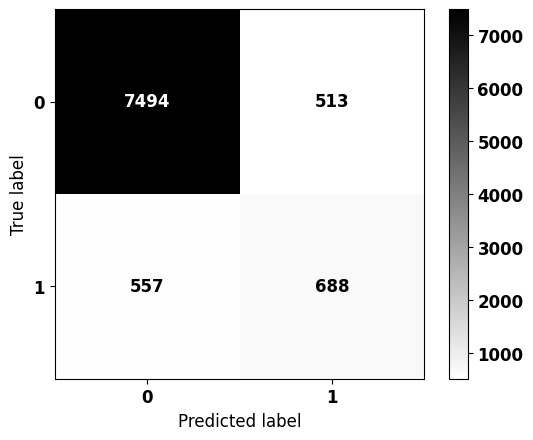


              precision    recall  f1-score   support

           0     0.9308    0.9359    0.9334      8007
           1     0.5729    0.5526    0.5626      1245

    accuracy                         0.8843      9252
   macro avg     0.7518    0.7443    0.7480      9252
weighted avg     0.8826    0.8843    0.8835      9252



In [91]:
# Pulmão
plot_confusion_matrix(best, X_test_pulm, y_test_pulm)
plot_confusion_matrix(best, X_test_pulm, y_test_pulm, norm=False)

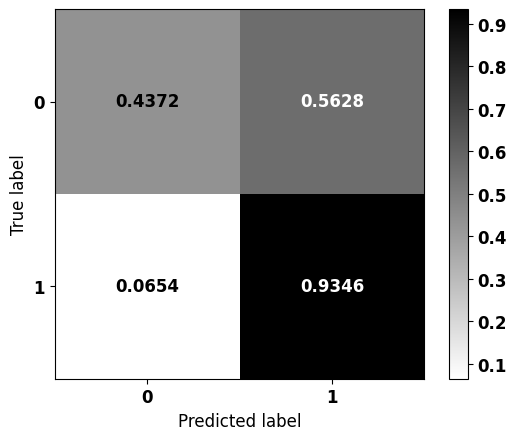


              precision    recall  f1-score   support

           0     0.8347    0.4372    0.5739      2310
           1     0.6873    0.9346    0.7921      3058

    accuracy                         0.7206      5368
   macro avg     0.7610    0.6859    0.6830      5368
weighted avg     0.7508    0.7206    0.6982      5368



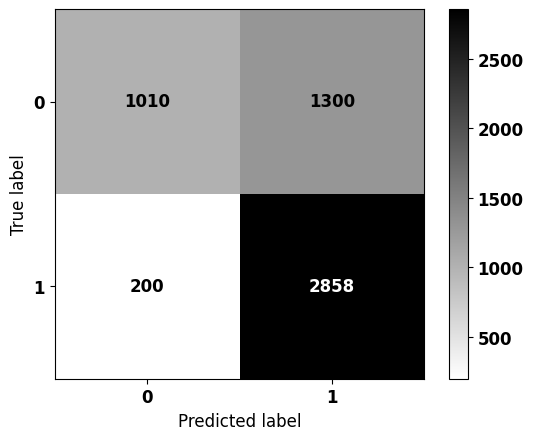


              precision    recall  f1-score   support

           0     0.8347    0.4372    0.5739      2310
           1     0.6873    0.9346    0.7921      3058

    accuracy                         0.7206      5368
   macro avg     0.7610    0.6859    0.6830      5368
weighted avg     0.7508    0.7206    0.6982      5368



In [92]:
# Colo de Útero
plot_confusion_matrix(best, X_test_colo_utero, y_test_colo_utero)
plot_confusion_matrix(best, X_test_colo_utero, y_test_colo_utero, norm=False)

## **Voting Classifier**


In [93]:
# Melhores hiperparâmetros do modelo XGBoost
xgb_score = xgb.score(X_test, y_test)
optuna_score = xgb_optuna.score(X_test, y_test)
print(f'Accuracy: XGB = {xgb_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= xgb_score:
    params_xgb = xgb_optuna.get_params()
    print('Otimizado venceu')
else:
    params_xgb = xgb.get_params()
    print('Modelo inicial venceu')

Accuracy: XGB = 0.8189, Optuna = 0.8242

Otimizado venceu


In [94]:
# Melhores hiperparâmetros do modelo LightGBM
lgbm_score = lgbm.score(X_test, y_test)
optuna_score = lgbm_optuna.score(X_test, y_test)
print(f'Accuracy: LGBM = {lgbm_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= lgbm_score:
    params_lgbm = lgbm_optuna.get_params()
    print('Otimizado venceu')
else:
    params_lgbm = lgbm.get_params()
    print('Modelo inicial venceu')

Accuracy: LGBM = 0.8218, Optuna = 0.8224

Otimizado venceu


In [95]:
# Criação dos modelos com os hiperparâmetros de melhor desempenho

# XGBoost
best_xgb = XGBClassifier()
best_xgb.set_params(**params_xgb)

# LightGBM
best_lgbm = LGBMClassifier()
best_lgbm.set_params(**params_lgbm)

LGBMClassifier(class_weight={0: 1, 1: 2.257}, colsample_bytree=0.3,
               learning_rate=0.2, max_depth=6, min_child_weight=1,
               n_estimators=102, random_state=7, verbose=-1)

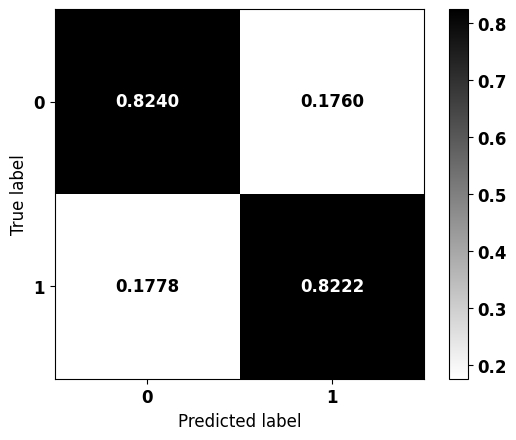


              precision    recall  f1-score   support

           0     0.9174    0.8240    0.8682     10317
           1     0.6608    0.8222    0.7327      4303

    accuracy                         0.8235     14620
   macro avg     0.7891    0.8231    0.8005     14620
weighted avg     0.8419    0.8235    0.8283     14620



In [96]:
from sklearn.ensemble import VotingClassifier

# Criação e treinamento do modelo de votação
clf = VotingClassifier(estimators=[('XGBoost', best_xgb),
                                   ('LightGBM', best_lgbm)
                                   ],
                       voting='soft')

clf.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(clf, X_test, y_test)

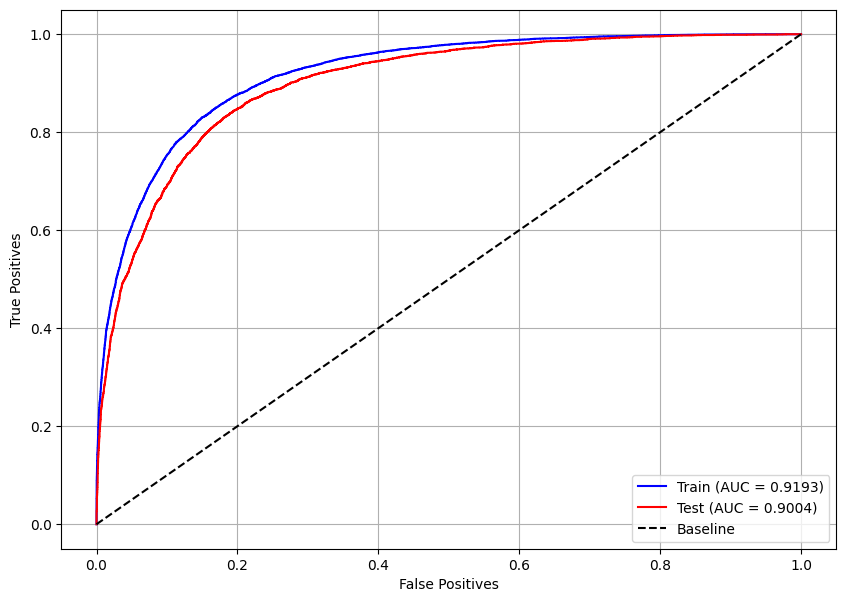

In [97]:
# Curva ROC do melhor modelo de votação
plot_roc_curve(clf, X_train, X_test, y_train, y_test)

# **Colo de Útero com Mama e Pulmão**

In [ ]:
df2_treino.TOPOGRUP.value_counts()

Mama             78399
Pulmão           27753
Colo de Útero    16102
Name: TOPOGRUP, dtype: int64

In [ ]:
# Valores faltantes
df2_treino.isna().sum().sort_values(ascending=False)

IDADE                 0
CONSDIAG              0
TOPOGRUP              0
presenca_rec          0
IBGE_idem_IBGEATEN    0
ESCOLARI_preench      0
HABILIT2              0
IBGEATEN              0
RRAS                  0
DRS                   0
ANODIAG               0
DIAGTRAT              0
OUTROS                0
SEXO                  0
IMUNO                 0
TMO                   0
HORMONIO              0
QUIMIO                0
RADIO                 0
CIRURGIA              0
EC                    0
DIAGPREV              0
CATEATEND             0
IBGE                  0
sobrevida_3anos       0
dtype: int64

In [ ]:
# Quantidade de pacientes em cada classe da saída
df2_treino.sobrevida_3anos.value_counts()

1    75766
0    46488
Name: sobrevida_3anos, dtype: int64

## **Pré-processamento**

In [ ]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df2_treino['TOPOGRUP'] = oe.fit_transform(df2_treino[['TOPOGRUP']])
df2_teste['TOPOGRUP'] = oe.transform(df2_teste[['TOPOGRUP']])

ss = StandardScaler()
df2_treino['TOPOGRUP'] = ss.fit_transform(df2_treino[['TOPOGRUP']])
df2_teste['TOPOGRUP'] = ss.transform(df2_teste[['TOPOGRUP']])

In [ ]:
# Dados pré-processados
list_drop = ['sobrevida_3anos']

# Treino
X_train = df2_treino.drop(columns=list_drop).copy()
y_train = df2_treino.sobrevida_3anos.copy()

# Teste
X_test = df2_teste.drop(columns=list_drop).copy()
y_test = df2_teste.sobrevida_3anos.copy()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((122254, 24), (122254,), (40753, 24), (40753,))

In [ ]:
feat_cols = X_train.columns
feat_cols

Index(['IDADE', 'SEXO', 'IBGE', 'CATEATEND', 'DIAGPREV', 'EC', 'CIRURGIA',
       'RADIO', 'QUIMIO', 'HORMONIO', 'TMO', 'IMUNO', 'OUTROS', 'CONSDIAG',
       'DIAGTRAT', 'ANODIAG', 'DRS', 'RRAS', 'IBGEATEN', 'HABILIT2',
       'ESCOLARI_preench', 'IBGE_idem_IBGEATEN', 'presenca_rec', 'TOPOGRUP'],
      dtype='object')

## **Treinamento e validação dos modelos de machine learning**

### **XGBoost**


#### **Modelo base**

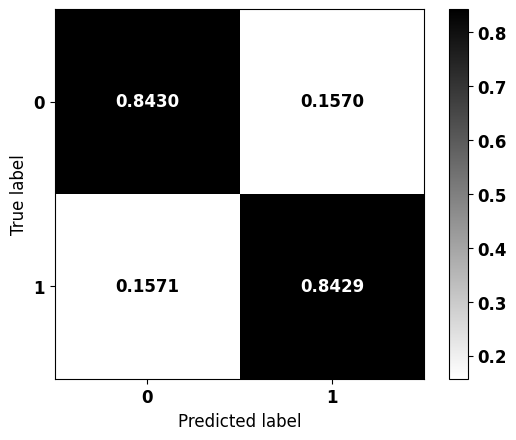


              precision    recall  f1-score   support

           0     0.7671    0.8430    0.8032     15497
           1     0.8974    0.8429    0.8693     25256

    accuracy                         0.8430     40753
   macro avg     0.8323    0.8430    0.8363     40753
weighted avg     0.8479    0.8430    0.8442     40753



In [ ]:
# Criação e treinamento do modelo XGBoost
xgb = XGBClassifier(max_depth=6,
                    scale_pos_weight=0.566,
                    random_state=seed)

xgb.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(xgb, X_test, y_test)

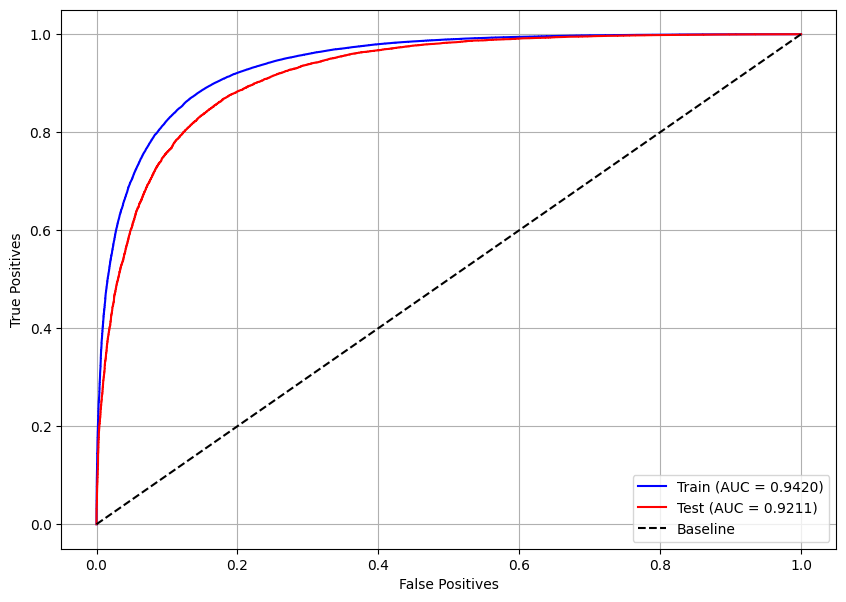

In [ ]:
# Curva ROC
plot_roc_curve(xgb, X_train, X_test, y_train, y_test)

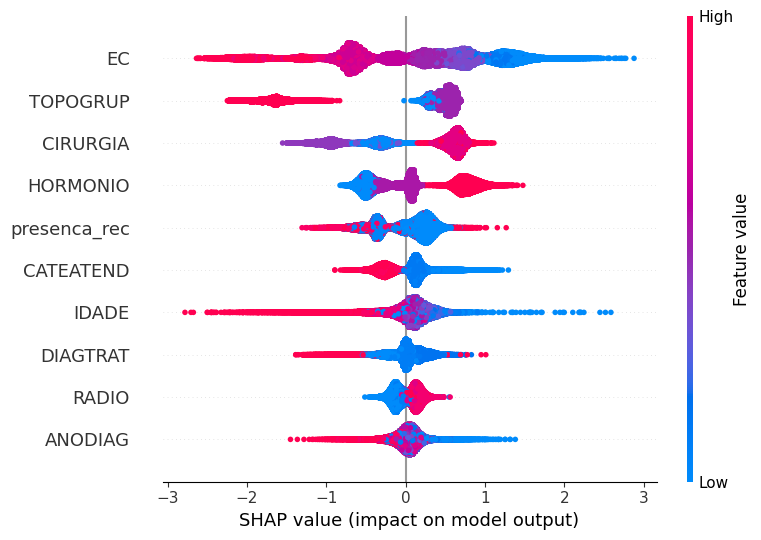

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb, X_train, feat_cols)

#### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 6)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05)
    gamma = trial.suggest_float('gamma', 0.0, 0.3, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = XGBClassifier(n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        gamma=gamma,
                        min_child_weight=min_child_weight,
                        colsample_bytree=colsample_bytree,
                        random_state=seed,
                        n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 141,
 'max_depth': 6,
 'learning_rate': 0.2,
 'gamma': 0.2,
 'min_child_weight': 6,
 'colsample_bytree': 0.4}

In [ ]:
pesos = np.round(np.arange(0.55, 0.575, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

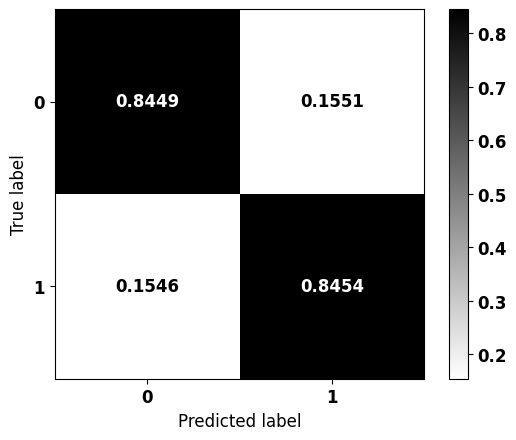


              precision    recall  f1-score   support

           0     0.7703    0.8449    0.8059     15497
           1     0.8988    0.8454    0.8713     25256

    accuracy                         0.8452     40753
   macro avg     0.8346    0.8452    0.8386     40753
weighted avg     0.8500    0.8452    0.8464     40753



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params

params['random_state'] = seed
params['scale_pos_weight'] = 0.572

xgb_rand = XGBClassifier()
xgb_rand.set_params(**params)

xgb_rand.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_rand, X_test, y_test)

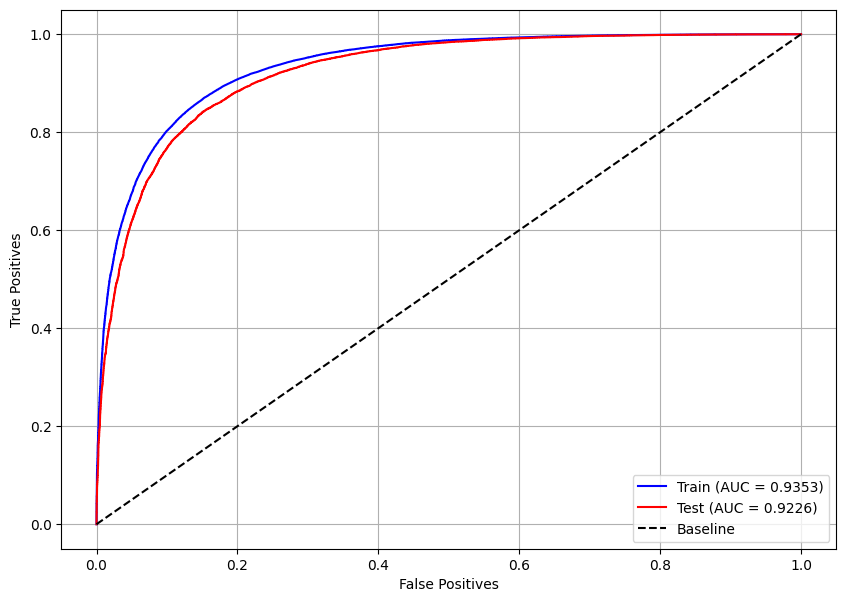

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_rand, X_train, X_test, y_train, y_test)

TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 127,
 'max_depth': 6,
 'learning_rate': 0.2,
 'gamma': 0.2,
 'min_child_weight': 6,
 'colsample_bytree': 0.4}

In [ ]:
pesos = np.round(np.arange(0.55, 0.575, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

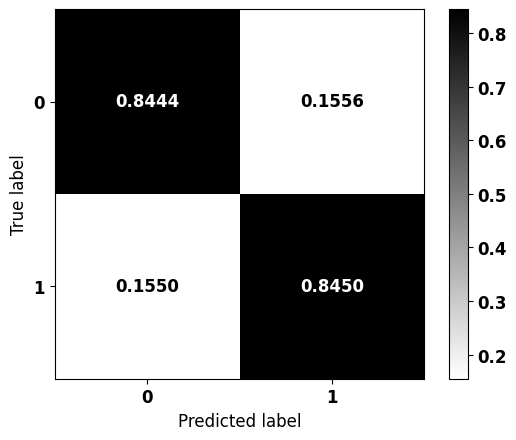


              precision    recall  f1-score   support

           0     0.7697    0.8444    0.8053     15497
           1     0.8985    0.8450    0.8709     25256

    accuracy                         0.8448     40753
   macro avg     0.8341    0.8447    0.8381     40753
weighted avg     0.8495    0.8448    0.8460     40753



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.5665

xgb_tpe = XGBClassifier()
xgb_tpe.set_params(**params)

xgb_tpe.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_tpe, X_test, y_test)

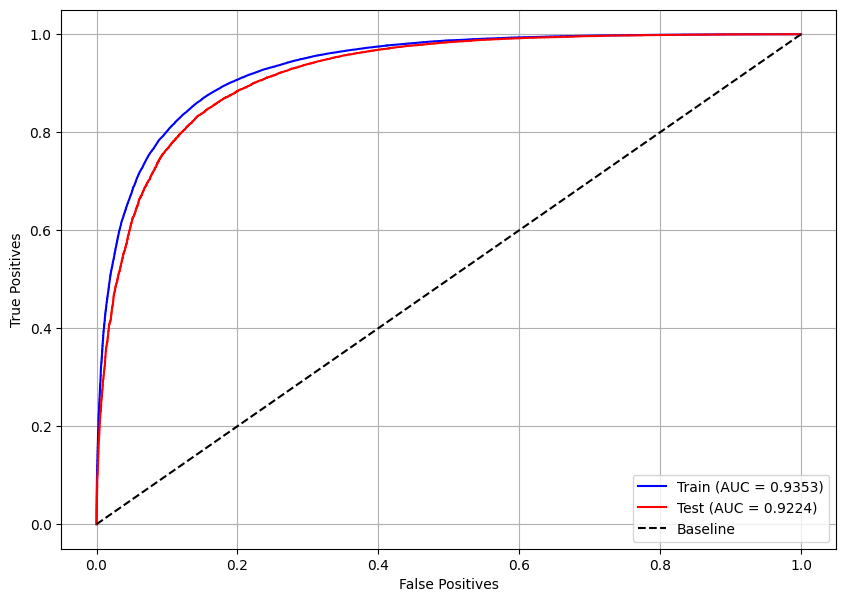

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_tpe, X_train, X_test, y_train, y_test)

CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 134,
 'max_depth': 6,
 'learning_rate': 0.15000000000000002,
 'gamma': 0.1,
 'min_child_weight': 6,
 'colsample_bytree': 0.4}

In [ ]:
pesos = np.round(np.arange(0.55, 0.575, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

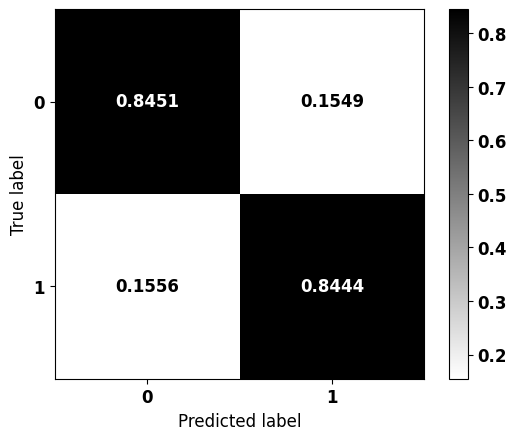


              precision    recall  f1-score   support

           0     0.7691    0.8451    0.8053     15497
           1     0.8988    0.8444    0.8707     25256

    accuracy                         0.8446     40753
   macro avg     0.8340    0.8447    0.8380     40753
weighted avg     0.8495    0.8446    0.8459     40753



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.5661

xgb_cma = XGBClassifier()
xgb_cma.set_params(**params)

xgb_cma.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_cma, X_test, y_test)

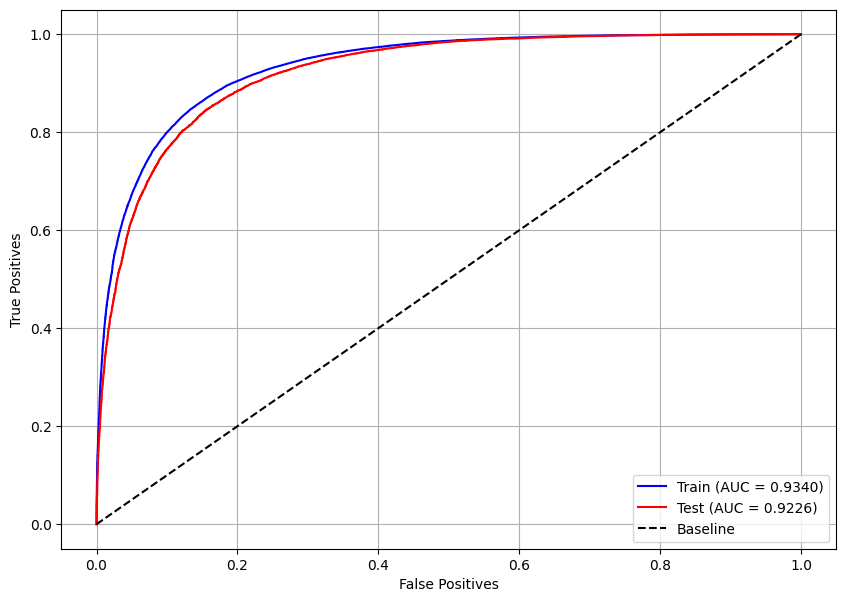

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_cma, X_train, X_test, y_train, y_test)

**Modelo Otimizado**

In [ ]:
# Melhor modelo
models = [xgb_rand, xgb_tpe, xgb_cma]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=141, n_jobs=None,
              num_parallel_tree=None, random_state=7, ...)


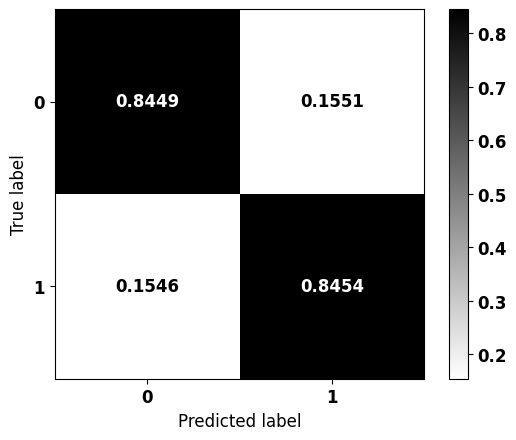


              precision    recall  f1-score   support

           0     0.7703    0.8449    0.8059     15497
           1     0.8988    0.8454    0.8713     25256

    accuracy                         0.8452     40753
   macro avg     0.8346    0.8452    0.8386     40753
weighted avg     0.8500    0.8452    0.8464     40753



In [ ]:
# Modelo com os melhores parâmetros
params = best.get_params()

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

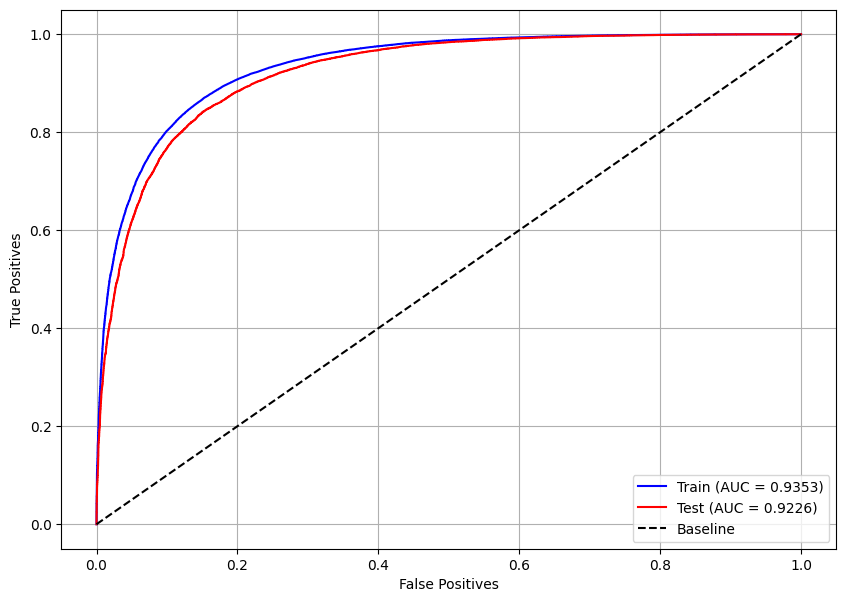

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

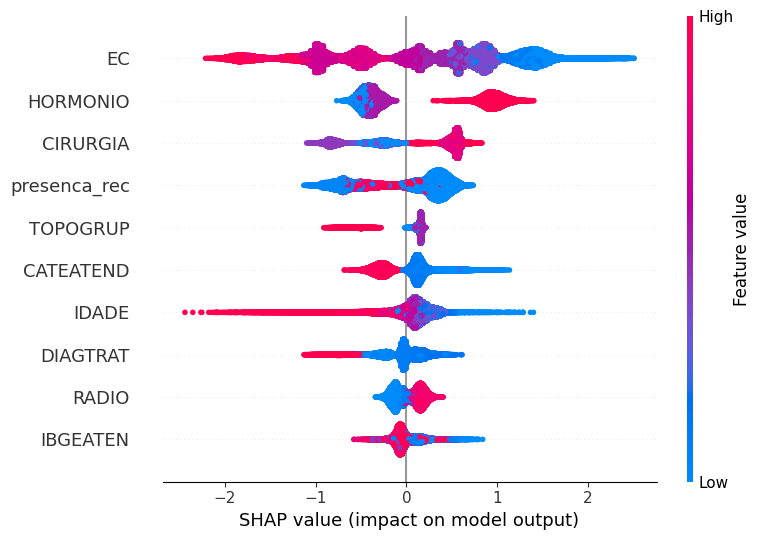

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb_optuna, X_train, feat_cols)

### **LightGBM**


#### **Modelo base**

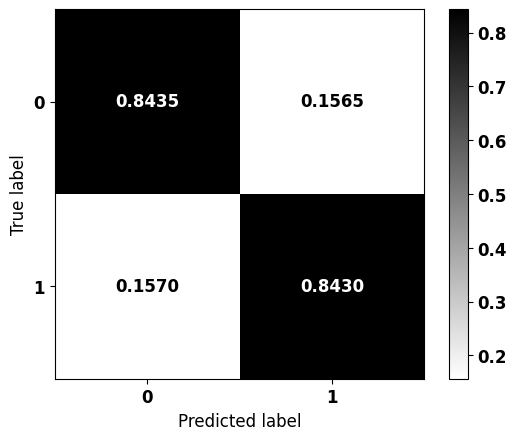


              precision    recall  f1-score   support

           0     0.7673    0.8435    0.8036     15497
           1     0.8977    0.8430    0.8695     25256

    accuracy                         0.8432     40753
   macro avg     0.8325    0.8433    0.8366     40753
weighted avg     0.8481    0.8432    0.8444     40753



In [ ]:
# Criação e treinamento do modelo LightGBM
lgbm = LGBMClassifier(max_depth=10,
                      class_weight={0:1.665, 1:1},
                      random_state=seed,
                      verbose=-1)

lgbm.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(lgbm, X_test, y_test)

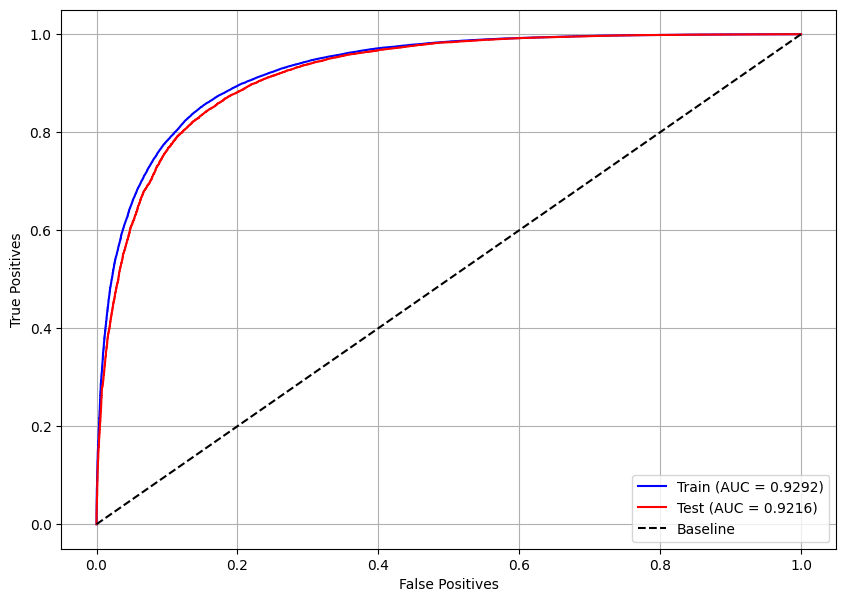

In [ ]:
# Curva ROC
plot_roc_curve(lgbm, X_train, X_test, y_train, y_test)

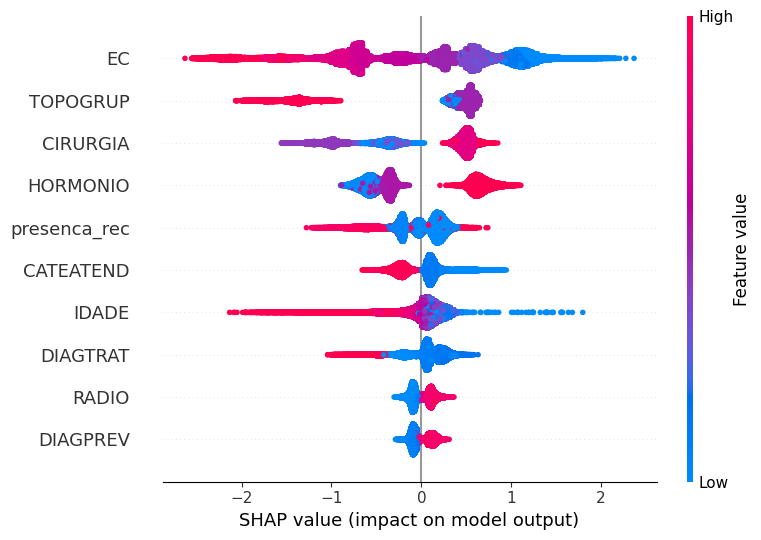

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm, X_train, feat_cols)

#### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.01)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = LGBMClassifier(n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         colsample_bytree=colsample_bytree,
                         random_state=seed,
                         verbose=-1,
                         n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 144,
 'max_depth': 8,
 'learning_rate': 0.12000000000000001,
 'min_child_weight': 4,
 'colsample_bytree': 0.7}

In [ ]:
pesos = np.round(np.arange(1.7, 1.74, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

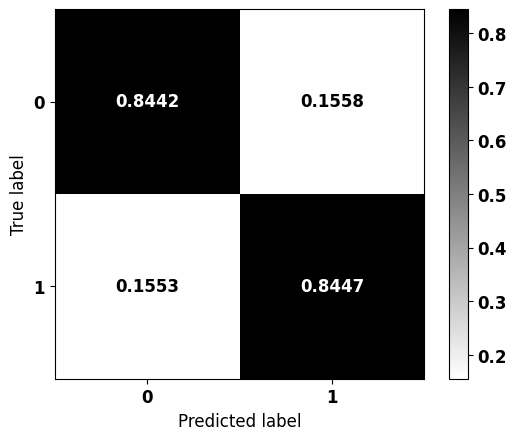


              precision    recall  f1-score   support

           0     0.7694    0.8442    0.8051     15497
           1     0.8984    0.8447    0.8707     25256

    accuracy                         0.8446     40753
   macro avg     0.8339    0.8445    0.8379     40753
weighted avg     0.8493    0.8446    0.8458     40753



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:1.733, 1:1}

lgbm_rand = LGBMClassifier(verbose=-1)
lgbm_rand.set_params(**params)

lgbm_rand.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_rand, X_test, y_test)

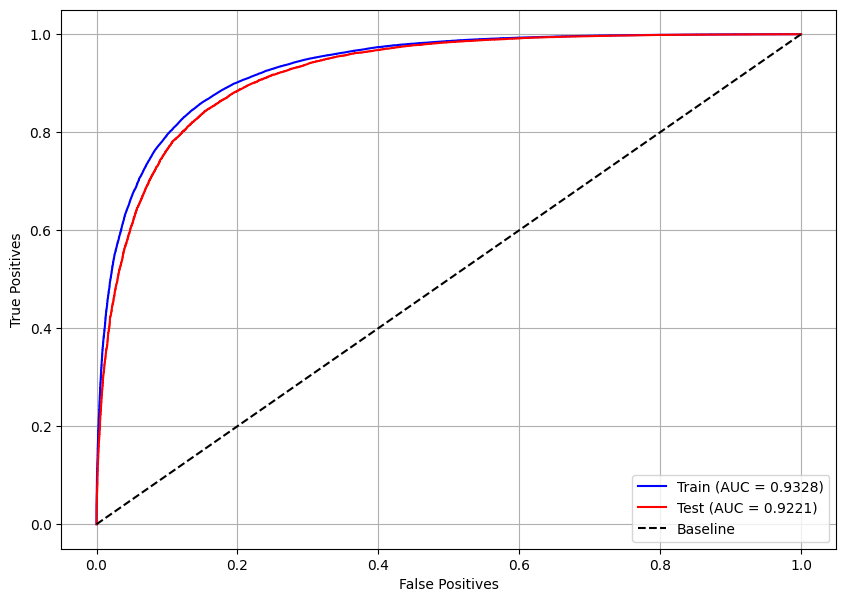

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_rand, X_train, X_test, y_train, y_test)

TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 124,
 'max_depth': 9,
 'learning_rate': 0.2,
 'min_child_weight': 5,
 'colsample_bytree': 0.6000000000000001}

In [ ]:
pesos = np.round(np.arange(1.74, 1.78, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

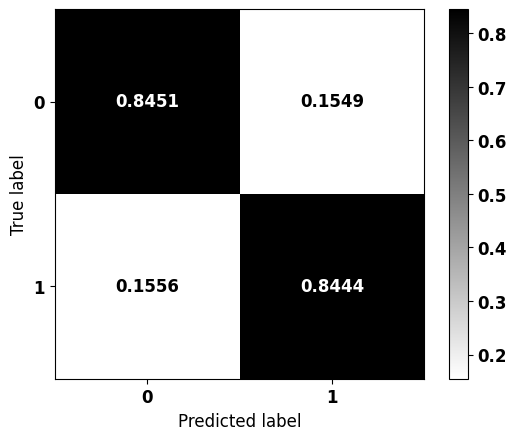


              precision    recall  f1-score   support

           0     0.7692    0.8451    0.8054     15497
           1     0.8988    0.8444    0.8708     25256

    accuracy                         0.8447     40753
   macro avg     0.8340    0.8448    0.8381     40753
weighted avg     0.8495    0.8447    0.8459     40753



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:1.752, 1:1}

lgbm_tpe = LGBMClassifier(verbose=-1)
lgbm_tpe.set_params(**params)

lgbm_tpe.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_tpe, X_test, y_test)

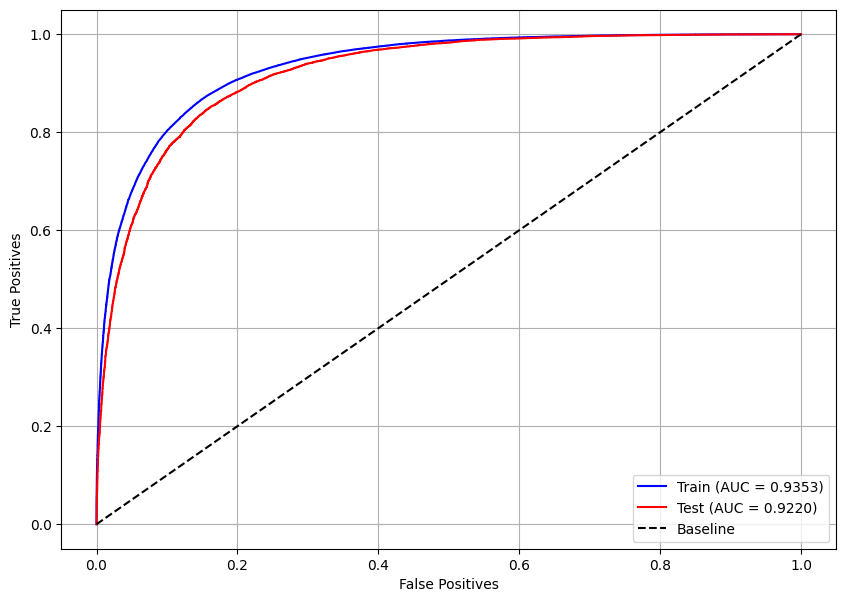

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_tpe, X_train, X_test, y_train, y_test)

CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 135,
 'max_depth': 9,
 'learning_rate': 0.15000000000000002,
 'min_child_weight': 6,
 'colsample_bytree': 0.6000000000000001}

In [ ]:
pesos = np.round(np.arange(1.72, 1.76, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

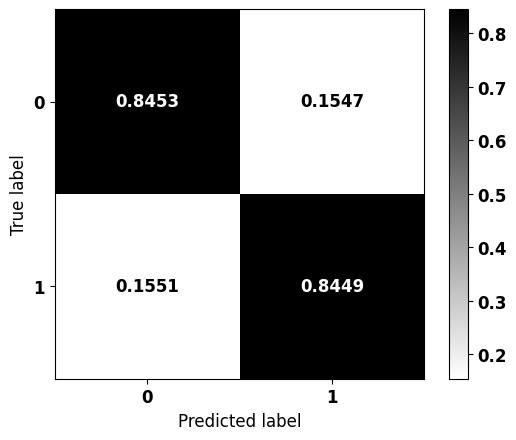


              precision    recall  f1-score   support

           0     0.7698    0.8453    0.8057     15497
           1     0.8990    0.8449    0.8711     25256

    accuracy                         0.8450     40753
   macro avg     0.8344    0.8451    0.8384     40753
weighted avg     0.8498    0.8450    0.8462     40753



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:1.732, 1:1}

lgbm_cma = LGBMClassifier(verbose=-1)
lgbm_cma.set_params(**params)

lgbm_cma.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_cma, X_test, y_test)

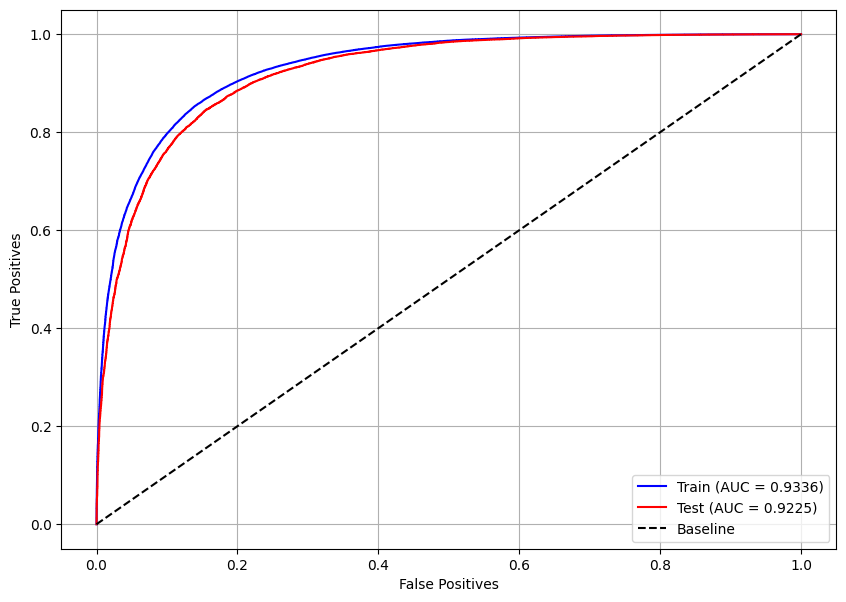

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_cma, X_train, X_test, y_train, y_test)

**Modelo Otimizado**

In [ ]:
# Melhor modelo
models = [lgbm_rand, lgbm_tpe, lgbm_cma]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

LGBMClassifier(class_weight={0: 1.732, 1: 1},
               colsample_bytree=0.6000000000000001,
               learning_rate=0.15000000000000002, max_depth=9,
               min_child_weight=6, n_estimators=135, random_state=7,
               verbose=-1)


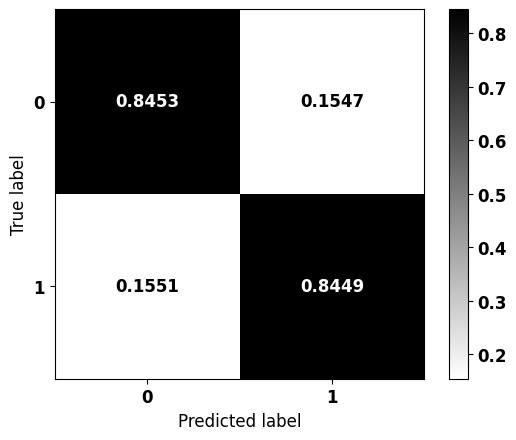


              precision    recall  f1-score   support

           0     0.7698    0.8453    0.8057     15497
           1     0.8990    0.8449    0.8711     25256

    accuracy                         0.8450     40753
   macro avg     0.8344    0.8451    0.8384     40753
weighted avg     0.8498    0.8450    0.8462     40753



In [ ]:
# Modelo com os melhores parâmetros
params = best.get_params()

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

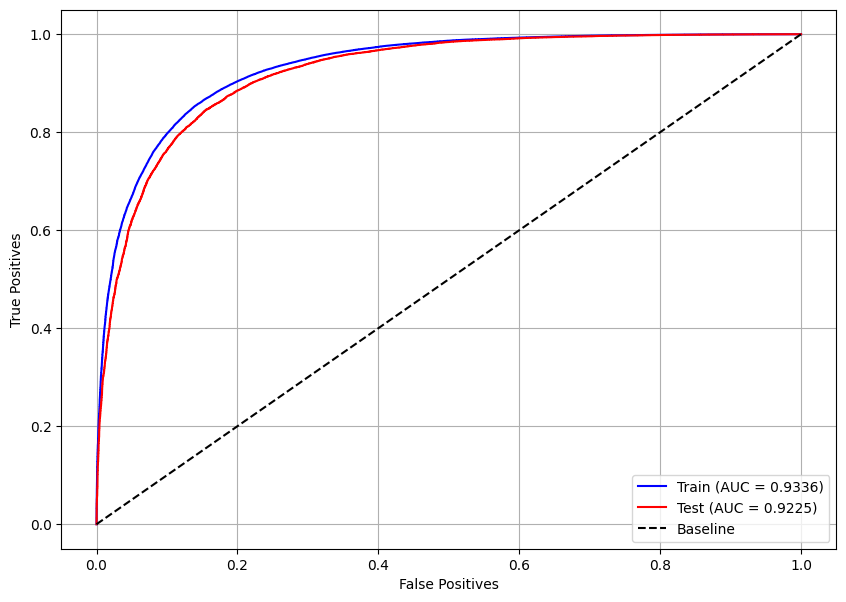

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


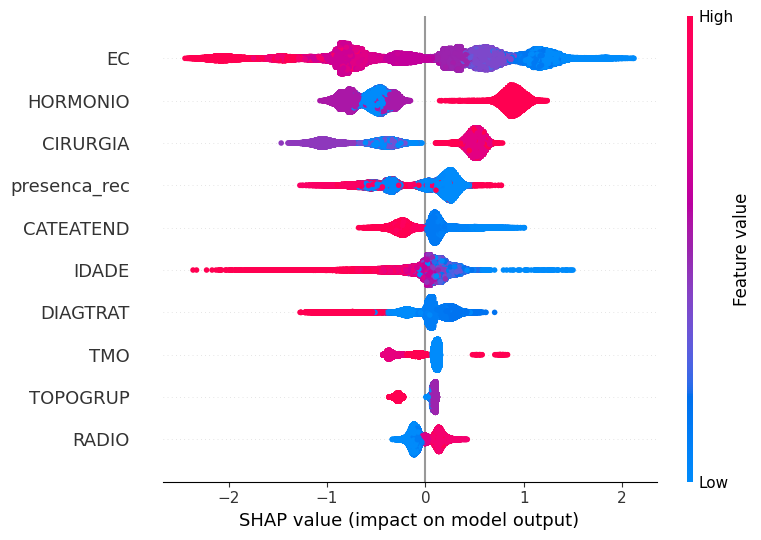

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm_optuna, X_train, feat_cols)

## **Testes cruzados**

In [ ]:
# Melhor modelo
models = [xgb, xgb_optuna, lgbm, lgbm_optuna]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=141, n_jobs=None,
              num_parallel_tree=None, random_state=7, ...)


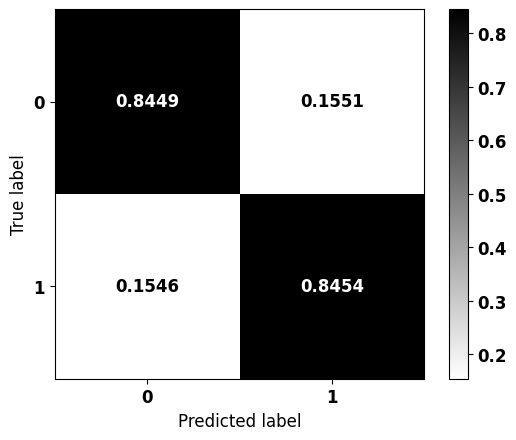


              precision    recall  f1-score   support

           0     0.7703    0.8449    0.8059     15497
           1     0.8988    0.8454    0.8713     25256

    accuracy                         0.8452     40753
   macro avg     0.8346    0.8452    0.8386     40753
weighted avg     0.8500    0.8452    0.8464     40753



In [ ]:
plot_confusion_matrix(best, X_test, y_test)

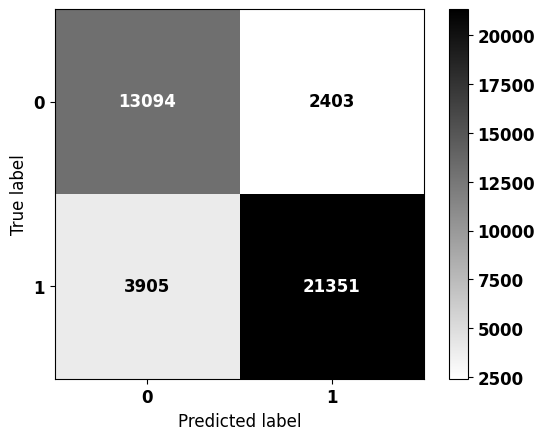


              precision    recall  f1-score   support

           0     0.7703    0.8449    0.8059     15497
           1     0.8988    0.8454    0.8713     25256

    accuracy                         0.8452     40753
   macro avg     0.8346    0.8452    0.8386     40753
weighted avg     0.8500    0.8452    0.8464     40753



In [ ]:
plot_confusion_matrix(best, X_test, y_test, norm=False)

In [ ]:
# Colo de Útero
X_test_colo_utero = colo_utero_teste.drop(columns=list_drop).copy()
y_test_colo_utero = colo_utero_teste.sobrevida_3anos.copy()

X_test_colo_utero['TOPOGRUP'] = oe.transform(X_test_colo_utero[['TOPOGRUP']])
X_test_colo_utero['TOPOGRUP'] = ss.transform(X_test_colo_utero[['TOPOGRUP']])

# Mama
X_test_mama = mama_teste.drop(columns=list_drop).copy()
y_test_mama = mama_teste.sobrevida_3anos.copy()

X_test_mama['TOPOGRUP'] = oe.transform(X_test_mama[['TOPOGRUP']])
X_test_mama['TOPOGRUP'] = ss.transform(X_test_mama[['TOPOGRUP']])

# Pulmão
X_test_pulm = pulm_teste.drop(columns=list_drop).copy()
y_test_pulm = pulm_teste.sobrevida_3anos.copy()

X_test_pulm['TOPOGRUP'] = oe.transform(X_test_pulm[['TOPOGRUP']])
X_test_pulm['TOPOGRUP'] = ss.transform(X_test_pulm[['TOPOGRUP']])

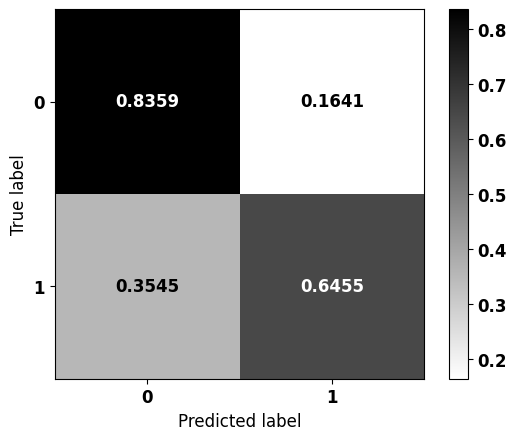


              precision    recall  f1-score   support

           0     0.6405    0.8359    0.7253      2310
           1     0.8389    0.6455    0.7296      3058

    accuracy                         0.7275      5368
   macro avg     0.7397    0.7407    0.7274      5368
weighted avg     0.7535    0.7275    0.7277      5368



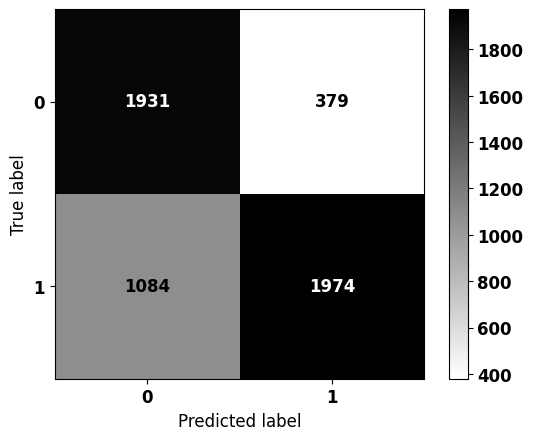


              precision    recall  f1-score   support

           0     0.6405    0.8359    0.7253      2310
           1     0.8389    0.6455    0.7296      3058

    accuracy                         0.7275      5368
   macro avg     0.7397    0.7407    0.7274      5368
weighted avg     0.7535    0.7275    0.7277      5368



In [ ]:
# Colo de Útero
plot_confusion_matrix(best, X_test_colo_utero, y_test_colo_utero)
plot_confusion_matrix(best, X_test_colo_utero, y_test_colo_utero, norm=False)

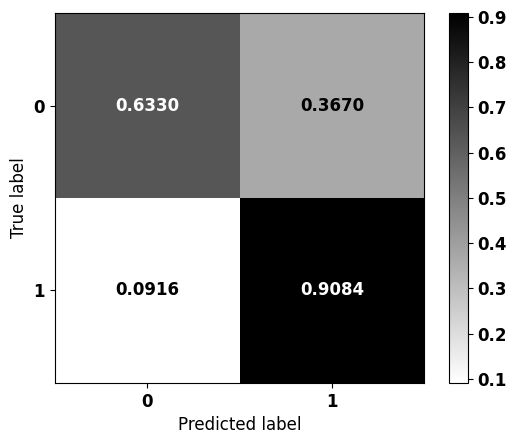


              precision    recall  f1-score   support

           0     0.6308    0.6330    0.6319      5180
           1     0.9092    0.9084    0.9088     20953

    accuracy                         0.8538     26133
   macro avg     0.7700    0.7707    0.7704     26133
weighted avg     0.8540    0.8538    0.8539     26133



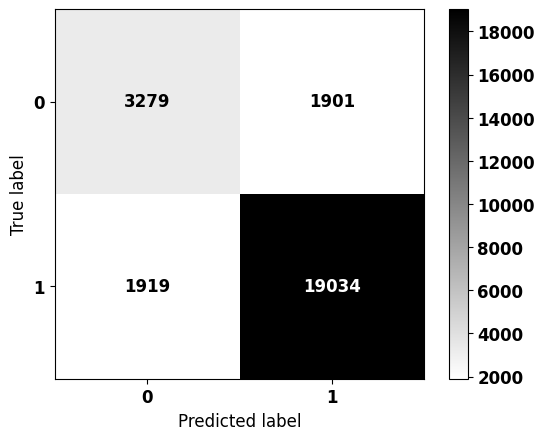


              precision    recall  f1-score   support

           0     0.6308    0.6330    0.6319      5180
           1     0.9092    0.9084    0.9088     20953

    accuracy                         0.8538     26133
   macro avg     0.7700    0.7707    0.7704     26133
weighted avg     0.8540    0.8538    0.8539     26133



In [ ]:
# Mama
plot_confusion_matrix(best, X_test_mama, y_test_mama)
plot_confusion_matrix(best, X_test_mama, y_test_mama, norm=False)

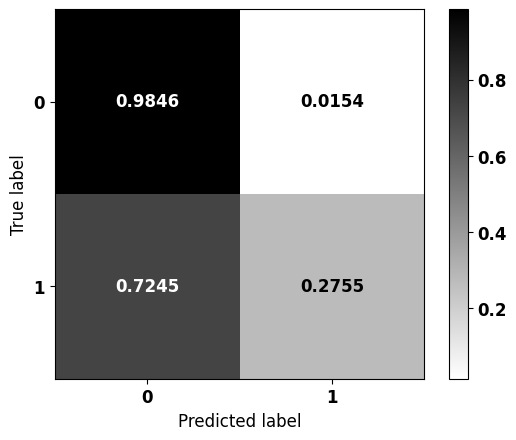


              precision    recall  f1-score   support

           0     0.8973    0.9846    0.9390      8007
           1     0.7361    0.2755    0.4009      1245

    accuracy                         0.8892      9252
   macro avg     0.8167    0.6301    0.6699      9252
weighted avg     0.8756    0.8892    0.8666      9252



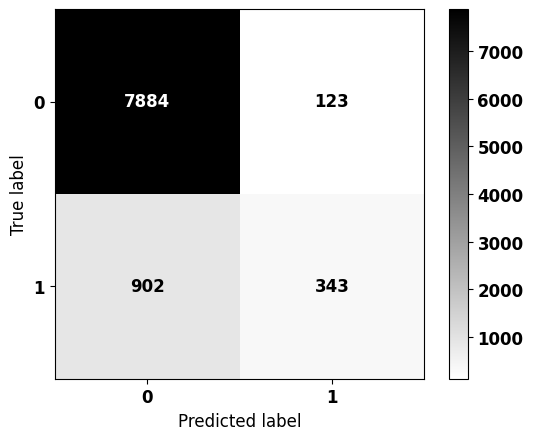


              precision    recall  f1-score   support

           0     0.8973    0.9846    0.9390      8007
           1     0.7361    0.2755    0.4009      1245

    accuracy                         0.8892      9252
   macro avg     0.8167    0.6301    0.6699      9252
weighted avg     0.8756    0.8892    0.8666      9252



In [ ]:
# Pulmão
plot_confusion_matrix(best, X_test_pulm, y_test_pulm)
plot_confusion_matrix(best, X_test_pulm, y_test_pulm, norm=False)

## **Voting Classifier**


In [ ]:
# Melhores hiperparâmetros do modelo XGBoost
xgb_score = xgb.score(X_test, y_test)
optuna_score = xgb_optuna.score(X_test, y_test)
print(f'Accuracy: XGB = {xgb_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= xgb_score:
    params_xgb = xgb_optuna.get_params()
    print('Otimizado venceu')
else:
    params_xgb = xgb.get_params()
    print('Modelo inicial venceu')

Accuracy: XGB = 0.8430, Optuna = 0.8452

Otimizado venceu


In [ ]:
# Melhores hiperparâmetros do modelo LightGBM
lgbm_score = lgbm.score(X_test, y_test)
optuna_score = lgbm_optuna.score(X_test, y_test)
print(f'Accuracy: LGBM = {lgbm_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= lgbm_score:
    params_lgbm = lgbm_optuna.get_params()
    print('Otimizado venceu')
else:
    params_lgbm = lgbm.get_params()
    print('Modelo inicial venceu')

Accuracy: LGBM = 0.8432, Optuna = 0.8450

Otimizado venceu


In [ ]:
# Criação dos modelos com os hiperparâmetros de melhor desempenho

# XGBoost
best_xgb = XGBClassifier()
best_xgb.set_params(**params_xgb)

# LightGBM
best_lgbm = LGBMClassifier()
best_lgbm.set_params(**params_lgbm)

LGBMClassifier(class_weight={0: 1.732, 1: 1},
               colsample_bytree=0.6000000000000001,
               learning_rate=0.15000000000000002, max_depth=9,
               min_child_weight=6, n_estimators=135, random_state=7,
               verbose=-1)

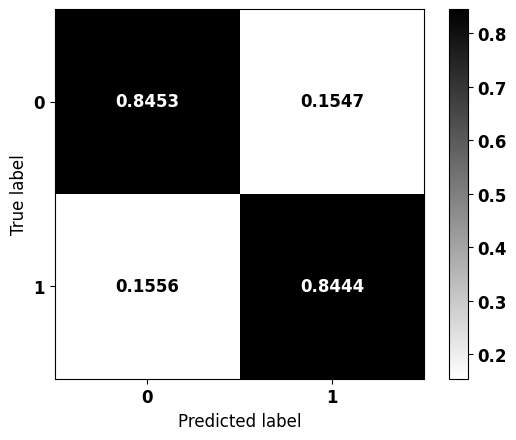


              precision    recall  f1-score   support

           0     0.7692    0.8453    0.8054     15497
           1     0.8989    0.8444    0.8708     25256

    accuracy                         0.8447     40753
   macro avg     0.8340    0.8448    0.8381     40753
weighted avg     0.8496    0.8447    0.8459     40753



In [ ]:
from sklearn.ensemble import VotingClassifier

# Criação e treinamento do modelo de votação
clf = VotingClassifier(estimators=[('XGBoost', best_xgb),
                                   ('LightGBM', best_lgbm)
                                   ],
                       voting='soft')

clf.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(clf, X_test, y_test)

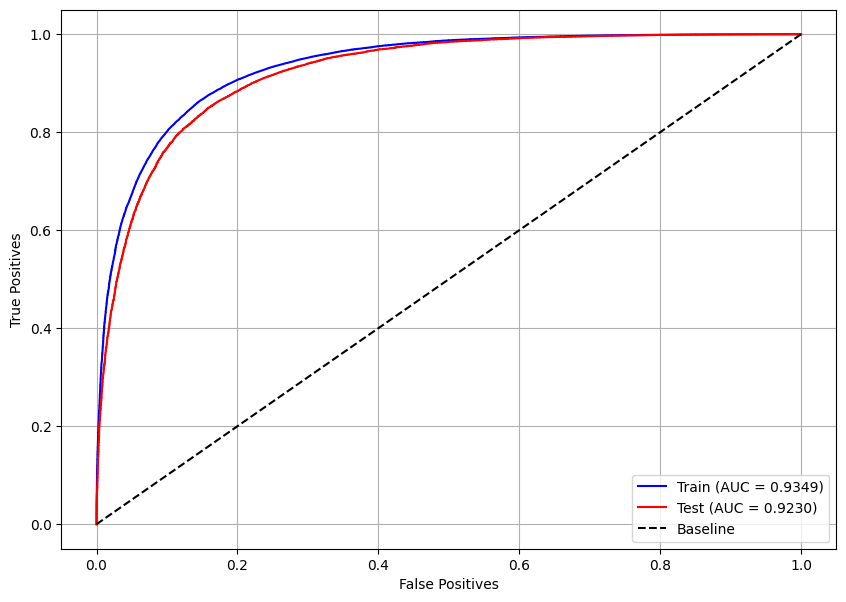

In [ ]:
# Curva ROC do melhor modelo de votação
plot_roc_curve(clf, X_train, X_test, y_train, y_test)